# Setup environment

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import copy
import pathlib
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from src.lightgbm_wrapper.station_embedding import learn_station_embeddings, attach_station_embedding
from sklearn.model_selection import train_test_split

from src.lightgbm_wrapper.feature_engineer import add_time_features, add_lag_features, add_rolling_features
from src.lightgbm_wrapper.plot import plot_1_data, plot_2_data
from src.lightgbm_wrapper.model import build_supervised_for_horizon, train_test_validation_split, train_lgbm_for_horizon, plot_timeseries_example

try:
    import lightgbm as lgb
except:
    print("lightgbm is not installed")

DATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station"
STATION_IDS = [211, 212, 213, 214, 215, 216]
#STATION_IDS = [211, 212, 213, 214, 216]
#STATION_IDS = [211, 212, 213, 216]

BASE_FEATURE_COLS = [
    "NO2_quantrac",
    "PM25_quantrac",
    "O3_quantrac",
    "CO_quantrac",
    "SO2_quantrac",
    #"Temperature_quantrac",
    #"Humid_quantrac",
]

# Define lag and rolling windows for feature engineering
#LAG_STEPS = [3, 6, 12, 24]
#ROLL_WINDOWS = [3, 6, 12, 24]
LAG_STEPS = [3, 6, 12, 24, 48, 71]
ROLL_WINDOWS = [3, 6, 12, 24, 48, 71]

# Define horizon (= n_past = n_future)
HORIZONS = [1, 24, 48, 72]

'''
# Directory to save the results and meta data
LIGHTGBM_DIR = f"/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/{datetime.now(timezone('Asia/Saigon')).strftime('%Y_%m_%d-%H_%M_%S')}"
pathlib.Path(LIGHTGBM_DIR).mkdir(parents=True, exist_ok=True)
print(LIGHTGBM_DIR)
with open(os.path.join(LIGHTGBM_DIR, "CONFIGURATIONS.txt"), "w") as f:
    f.write(f"BASE_FEATURE_COLS: {BASE_FEATURE_COLS}\n")
    f.write(f"LAG_STEPS: {LAG_STEPS}\n")
    f.write(f"ROLL_WINDOWS: {ROLL_WINDOWS}\n")
    f.write(f"HORIZONS: {HORIZONS}\n")
'''
    
# Store the results in one directory only, for testing API purpose
LIGHTGBM_DIR = f"/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/so2_testing_model"
if os.path.isdir(LIGHTGBM_DIR):
    import shutil
    shutil.rmtree(LIGHTGBM_DIR)
pathlib.Path(LIGHTGBM_DIR).mkdir(parents=True, exist_ok=True)
print(LIGHTGBM_DIR)
with open(os.path.join(LIGHTGBM_DIR, "CONFIGURATIONS.txt"), "w") as f:
    f.write(f"BASE_FEATURE_COLS: {BASE_FEATURE_COLS}\n")
    f.write(f"LAG_STEPS: {LAG_STEPS}\n")
    f.write(f"ROLL_WINDOWS: {ROLL_WINDOWS}\n")
    f.write(f"HORIZONS: {HORIZONS}\n")

/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/so2_testing_model


# Load dataset

In [2]:
def load_station_csv(station_id, data_dir=DATA_DIR):
    csv_path = os.path.join(data_dir, f"{station_id}.csv")
    df = pd.read_csv(csv_path)

    # Convert to datetime
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)

    # Remove unncessary column
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    # Add station_id column
    df["station_id"] = station_id
    return df

# Load dataset
dfs = []
for sid in STATION_IDS:
    df_sid = load_station_csv(sid, DATA_DIR)
    dfs.append(df_sid)
df_all = pd.concat(dfs, ignore_index=True)

# Sort data by station then date
df_all = df_all.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_all = df_all.loc[:, ["date"] + BASE_FEATURE_COLS + ["station_id"]]

print(df_all.shape)
print(df_all.columns)
df_all

(92966, 7)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'SO2_quantrac', 'station_id'],
      dtype='object')


date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0     2021-02-23 21:00:00    112.740762      15.604762    55.431381   
1     2021-02-23 22:00:00    112.366471      14.594118    58.197176   
2     2021-02-23 23:00:00    112.700433      13.436667    55.029433   
3     2021-02-24 00:00:00    112.480867      12.365000    54.767700   
4     2021-02-24 01:00:00    114.331500      11.636667    53.786200   
...                   ...           ...            ...          ...   
92961 2022-12-31 19:00:00      0.088233      41.450000    75.916667   
92962 2022-12-31 20:00:00      0.083217      50.530000    66.116667   
92963 2022-12-31 21:00:00      0.084300      55.055000    55.133333   
92964 2022-12-31 22:00:00      0.066650      26.078333    46.750000   
92965 2022-12-31 23:00:00      0.067783      21.161667    50.016667   

       CO_quantrac  SO2_quantrac  station_id  
0        90.000000           NaN         211  
1      1200.603529           NaN         211  
2      1177.897000           NaN         211  
3        90.000000           NaN         211  
4        90.000000           NaN         211  
...            ...           ...         ...  
92961     2.087167      0.105667         216  
92962     2.006500      0.104167         216  
92963     2.418833      0.130167         216  
92964     1.481500      0.075833         216  
92965     1.301167      0.060833         216  

[92966 rows x 7 columns]

In [3]:
df_all.isnull().sum()

date                 0
NO2_quantrac     43684
PM25_quantrac    43043
O3_quantrac      47797
CO_quantrac      43760
SO2_quantrac     75946
station_id           0
dtype: int64

# Data preparation

## Drop missing

Output: df_dropped

In [4]:
df_dropped = df_all.dropna().reset_index(drop=True)
df_dropped

date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0     2022-01-01 00:00:00      0.038059      27.601889    47.306123   
1     2022-01-01 01:00:00      0.036300      21.285000    44.916667   
2     2022-01-01 02:00:00      0.034759      18.414815    46.148148   
3     2022-01-01 03:00:00      0.035643      19.242857    46.357143   
4     2022-01-01 04:00:00      0.036550      18.140000    46.700000   
...                   ...           ...            ...          ...   
13614 2022-12-31 19:00:00      0.088233      41.450000    75.916667   
13615 2022-12-31 20:00:00      0.083217      50.530000    66.116667   
13616 2022-12-31 21:00:00      0.084300      55.055000    55.133333   
13617 2022-12-31 22:00:00      0.066650      26.078333    46.750000   
13618 2022-12-31 23:00:00      0.067783      21.161667    50.016667   

       CO_quantrac  SO2_quantrac  station_id  
0         0.910415      0.056186         214  
1         0.672500      0.042500         214  
2         0.577037      0.035926         214  
3         0.542143      0.030238         214  
4         0.507000      0.029667         214  
...            ...           ...         ...  
13614     2.087167      0.105667         216  
13615     2.006500      0.104167         216  
13616     2.418833      0.130167         216  
13617     1.481500      0.075833         216  
13618     1.301167      0.060833         216  

[13619 rows x 7 columns]

## Update the STATION_IDS after dropping missing

In [5]:
STATION_IDS = list(df_dropped["station_id"].unique())
STATION_IDS

[214, 216]

## Visualization

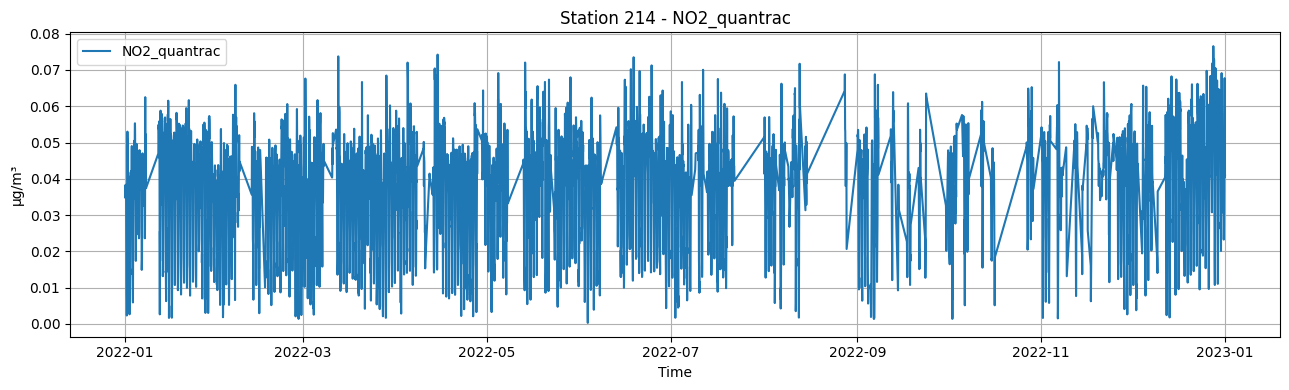

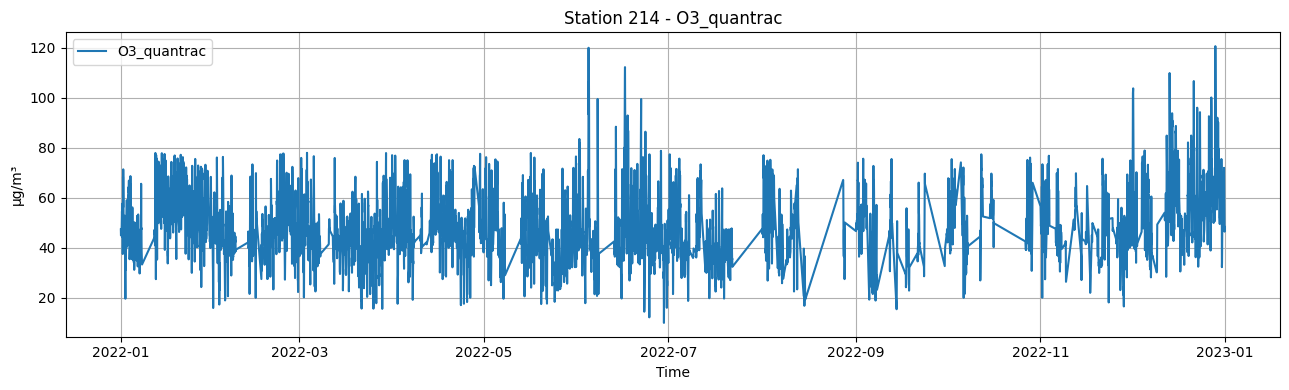

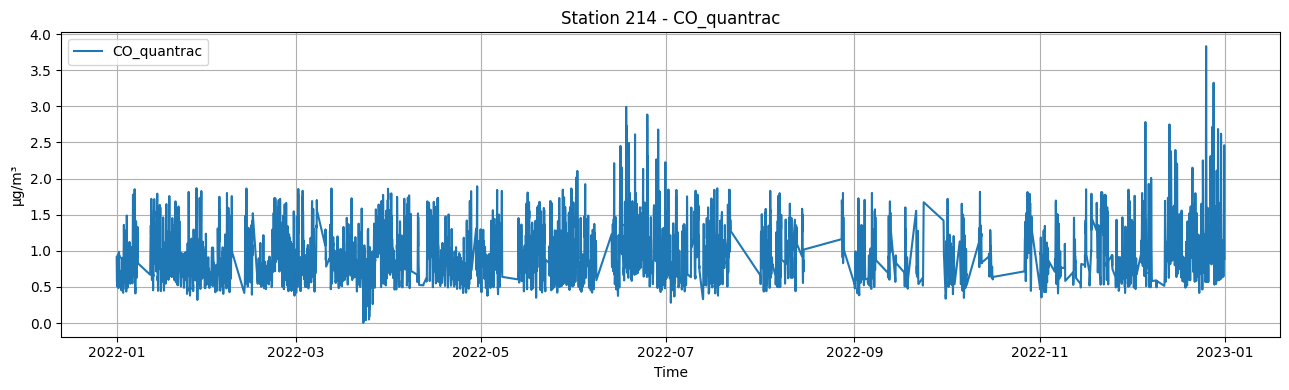

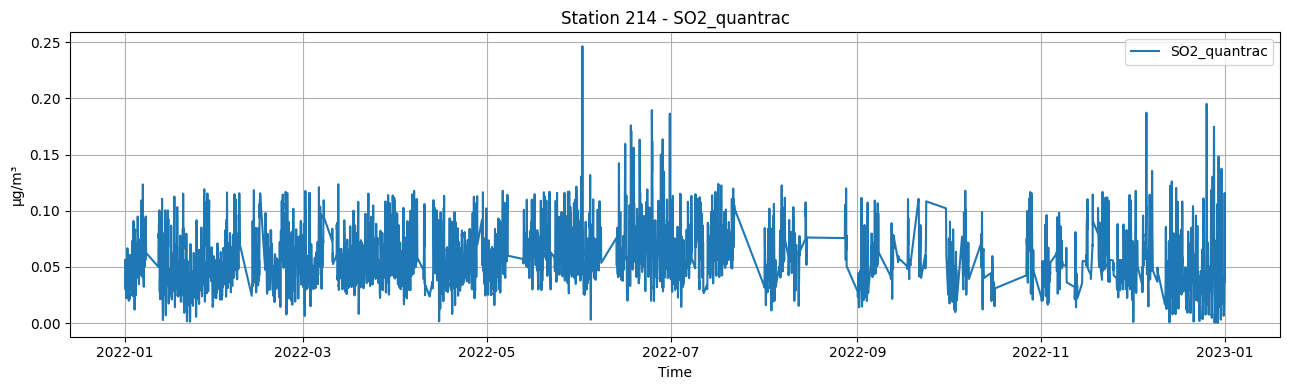

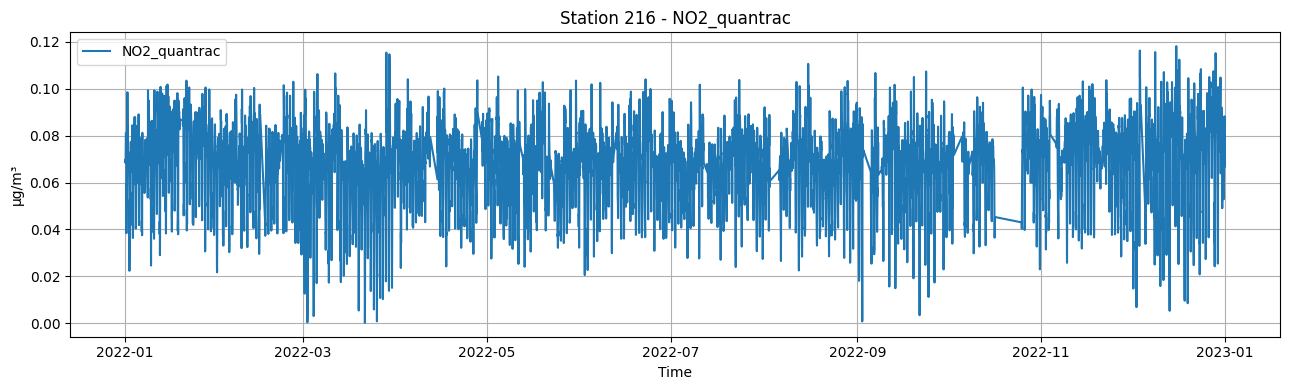

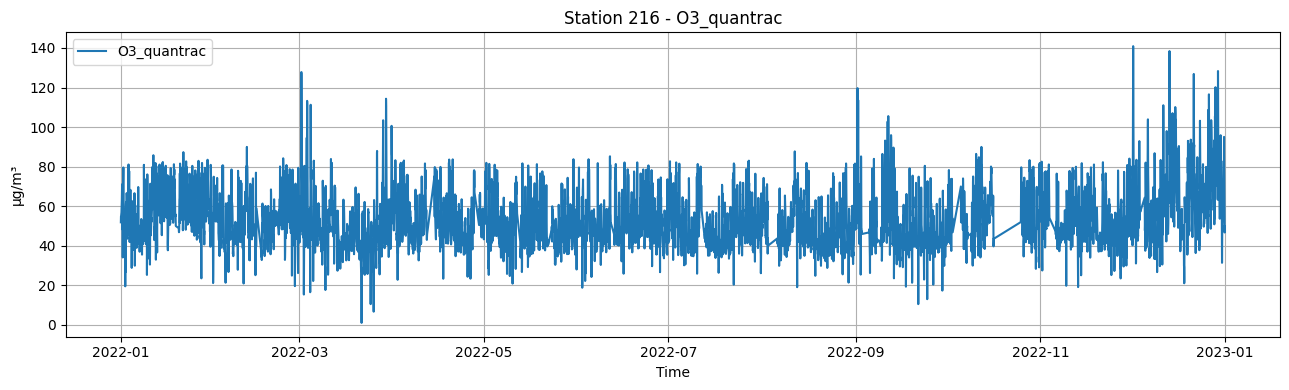

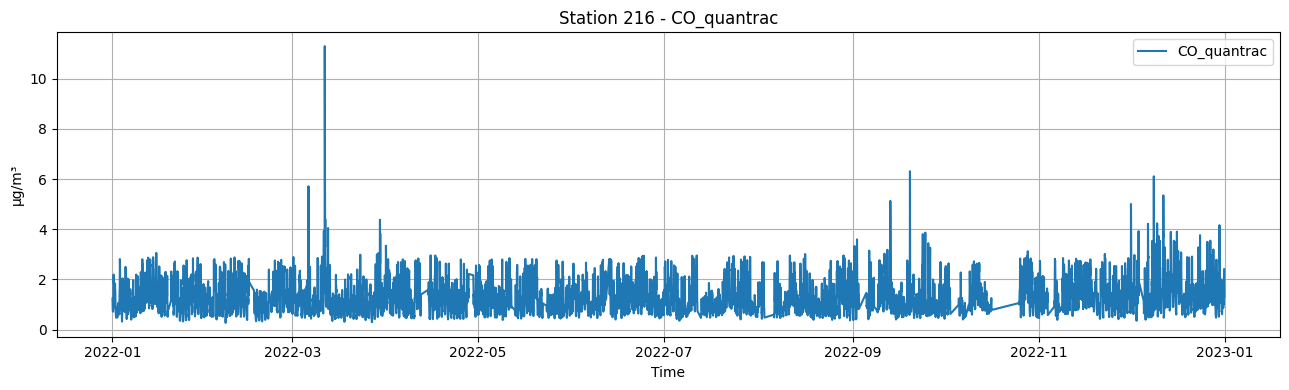

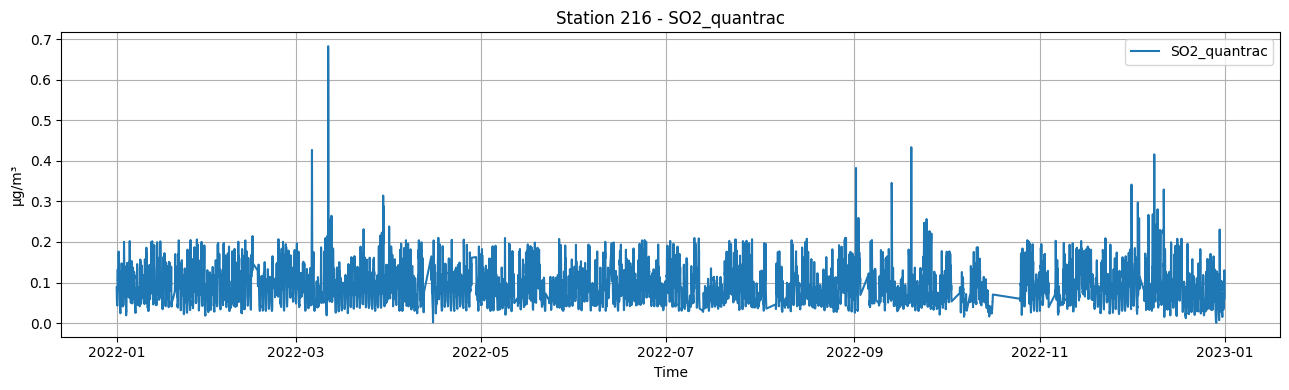

In [6]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, target_col, df_station["date"], f"Station {station} - {target_col}")
            #plot_1_data(df_station, target_col, target_col, df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Convert ppm to ug/m3

Apply only to station 216, year 2022 on NO2, CO columns

Output: df_converted

In [7]:
df_converted = copy.deepcopy(df_dropped)
#mask = (df_converted["station_id"] == 216) & (df_converted["date"] >= "2022-01-01")

print("=" * 50 + "BEFORE" + "=" * 50)
for station in STATION_IDS:
    display(df_converted[df_converted["station_id"] == station])

#mask_no2 = (df_converted["NO2_quantrac"] < 1.0)
#df_converted.loc[mask_no2, "NO2_quantrac"] = df_converted.loc[mask_no2, "NO2_quantrac"].apply(lambda x: x * 1883.2)
df_converted.loc[:, "NO2_quantrac"] = df_converted.loc[:, "NO2_quantrac"].apply(lambda x: x * 1883.2)

#mask_co = (df_converted["CO_quantrac"] < 1.0)
#df_converted.loc[mask_co, "CO_quantrac"] = df_converted.loc[mask_co, "CO_quantrac"].apply(lambda x: x * 1146.8)
df_converted.loc[:, "CO_quantrac"] = df_converted.loc[:, "CO_quantrac"].apply(lambda x: x * 1146.8)

#mask_so2 = (df_converted["SO2_quantrac"] < 1.0)
#df_converted.loc[mask_so2, "SO2_quantrac"] = df_converted.loc[mask_so2, "SO2_quantrac"].apply(lambda x: x * 2620)
df_converted.loc[:, "SO2_quantrac"] = df_converted.loc[:, "SO2_quantrac"].apply(lambda x: x * 2620)

print("=" * 50 + "AFTER" + "=" * 50)
for station in STATION_IDS:
    display(df_converted[df_converted["station_id"] == station])

==================================================BEFORE==================================================


date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0    2022-01-01 00:00:00      0.038059      27.601889    47.306123   
1    2022-01-01 01:00:00      0.036300      21.285000    44.916667   
2    2022-01-01 02:00:00      0.034759      18.414815    46.148148   
3    2022-01-01 03:00:00      0.035643      19.242857    46.357143   
4    2022-01-01 04:00:00      0.036550      18.140000    46.700000   
...                  ...           ...            ...          ...   
5712 2022-12-31 19:00:00      0.056867      39.078333    60.333333   
5713 2022-12-31 20:00:00      0.067750      44.953333    59.133333   
5714 2022-12-31 21:00:00      0.042678      30.510169    46.423729   
5715 2022-12-31 22:00:00      0.040466      22.584483    47.120690   
5716 2022-12-31 23:00:00      0.040833      20.395000    48.316667   

      CO_quantrac  SO2_quantrac  station_id  
0        0.910415      0.056186         214  
1        0.672500      0.042500         214  
2        0.577037      0.035926         214  
3        0.542143      0.030238         214  
4        0.507000      0.029667         214  
...           ...           ...         ...  
5712     1.778333      0.080333         214  
5713     2.461167      0.115833         214  
5714     1.356271      0.072712         214  
5715     0.938793      0.045690         214  
5716     0.889667      0.036500         214  

[5717 rows x 7 columns]

date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
5717  2022-01-01 00:00:00      0.068981      18.414899    51.895318   
5718  2022-01-01 01:00:00      0.069400      19.490000    54.933333   
5719  2022-01-01 02:00:00      0.068500      18.080000    55.033333   
5720  2022-01-01 03:00:00      0.069683      16.393333    55.700000   
5721  2022-01-01 04:00:00      0.069417      15.293333    55.916667   
...                   ...           ...            ...          ...   
13614 2022-12-31 19:00:00      0.088233      41.450000    75.916667   
13615 2022-12-31 20:00:00      0.083217      50.530000    66.116667   
13616 2022-12-31 21:00:00      0.084300      55.055000    55.133333   
13617 2022-12-31 22:00:00      0.066650      26.078333    46.750000   
13618 2022-12-31 23:00:00      0.067783      21.161667    50.016667   

       CO_quantrac  SO2_quantrac  station_id  
5717      1.238117      0.088139         216  
5718      0.930000      0.065333         216  
5719      0.788667      0.053167         216  
5720      0.732667      0.045167         216  
5721      0.717833      0.044500         216  
...            ...           ...         ...  
13614     2.087167      0.105667         216  
13615     2.006500      0.104167         216  
13616     2.418833      0.130167         216  
13617     1.481500      0.075833         216  
13618     1.301167      0.060833         216  

[7902 rows x 7 columns]

==================================================AFTER==================================================


date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0    2022-01-01 00:00:00     71.673644      27.601889    47.306123   
1    2022-01-01 01:00:00     68.360160      21.285000    44.916667   
2    2022-01-01 02:00:00     65.458637      18.414815    46.148148   
3    2022-01-01 03:00:00     67.122629      19.242857    46.357143   
4    2022-01-01 04:00:00     68.830960      18.140000    46.700000   
...                  ...           ...            ...          ...   
5712 2022-12-31 19:00:00    107.091307      39.078333    60.333333   
5713 2022-12-31 20:00:00    127.586800      44.953333    59.133333   
5714 2022-12-31 21:00:00     80.371146      30.510169    46.423729   
5715 2022-12-31 22:00:00     76.204662      22.584483    47.120690   
5716 2022-12-31 23:00:00     76.897333      20.395000    48.316667   

      CO_quantrac  SO2_quantrac  station_id  
0     1044.063623    147.206555         214  
1      771.223000    111.350000         214  
2      661.746074     94.125926         214  
3      621.729429     79.223810         214  
4      581.427600     77.726667         214  
...           ...           ...         ...  
5712  2039.392667    210.473333         214  
5713  2822.465933    303.483333         214  
5714  1555.371797    190.505085         214  
5715  1076.607931    119.706897         214  
5716  1020.269733     95.630000         214  

[5717 rows x 7 columns]

date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
5717  2022-01-01 00:00:00    129.905143      18.414899    51.895318   
5718  2022-01-01 01:00:00    130.694080      19.490000    54.933333   
5719  2022-01-01 02:00:00    128.999200      18.080000    55.033333   
5720  2022-01-01 03:00:00    131.227653      16.393333    55.700000   
5721  2022-01-01 04:00:00    130.725467      15.293333    55.916667   
...                   ...           ...            ...          ...   
13614 2022-12-31 19:00:00    166.161013      41.450000    75.916667   
13615 2022-12-31 20:00:00    156.713627      50.530000    66.116667   
13616 2022-12-31 21:00:00    158.753760      55.055000    55.133333   
13617 2022-12-31 22:00:00    125.515280      26.078333    46.750000   
13618 2022-12-31 23:00:00    127.649573      21.161667    50.016667   

       CO_quantrac  SO2_quantrac  station_id  
5717   1419.872305    230.924024         216  
5718   1066.524000    171.173333         216  
5719    904.442933    139.296667         216  
5720    840.222133    118.336667         216  
5721    823.211267    116.590000         216  
...            ...           ...         ...  
13614  2393.562733    276.846667         216  
13615  2301.054200    272.916667         216  
13616  2773.918067    341.036667         216  
13617  1698.984200    198.683333         216  
13618  1492.177933    159.383333         216  

[7902 rows x 7 columns]

## Visualization after converting unit

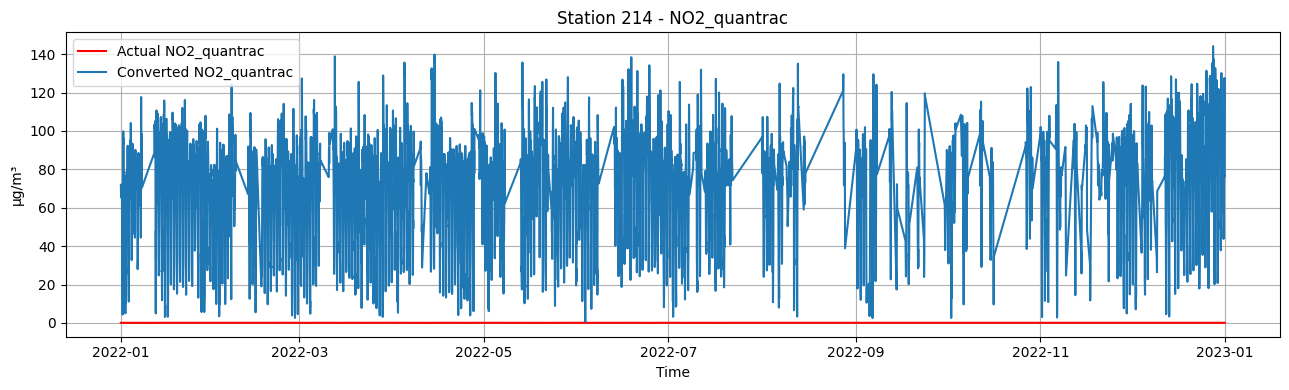

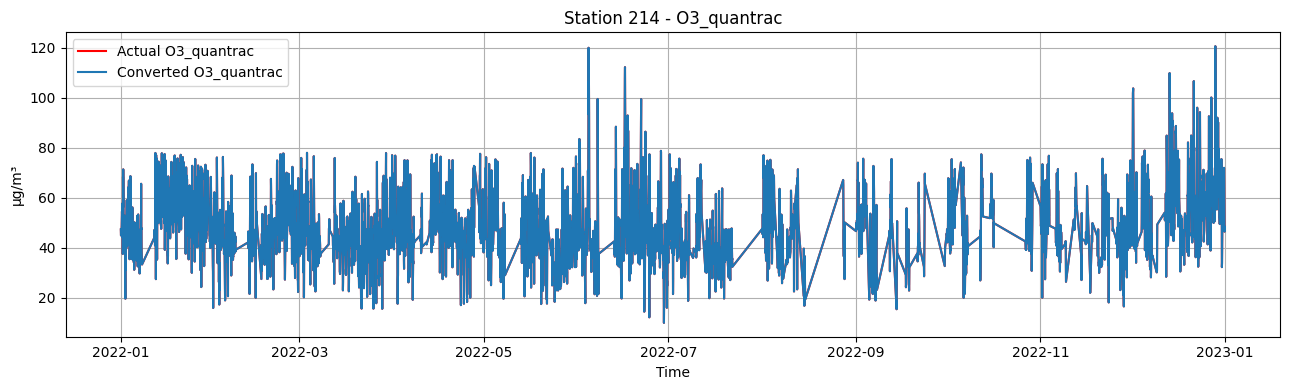

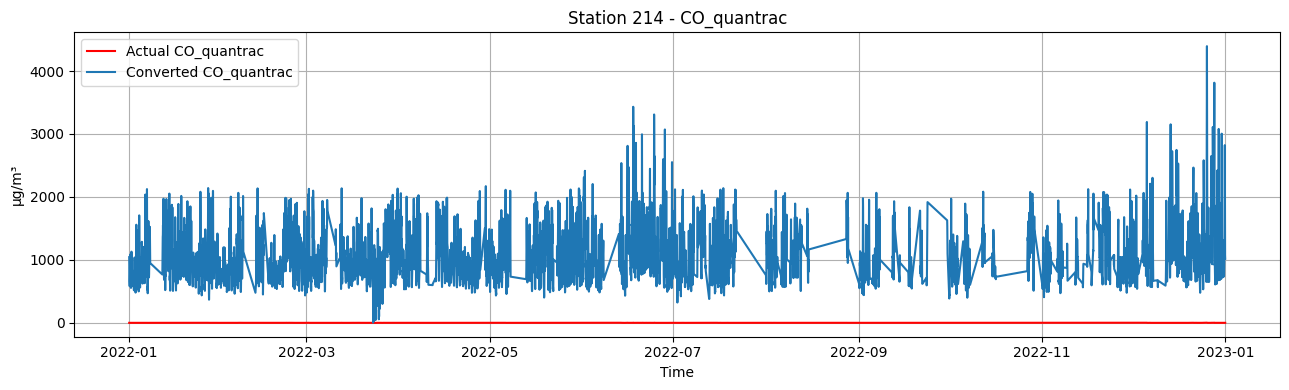

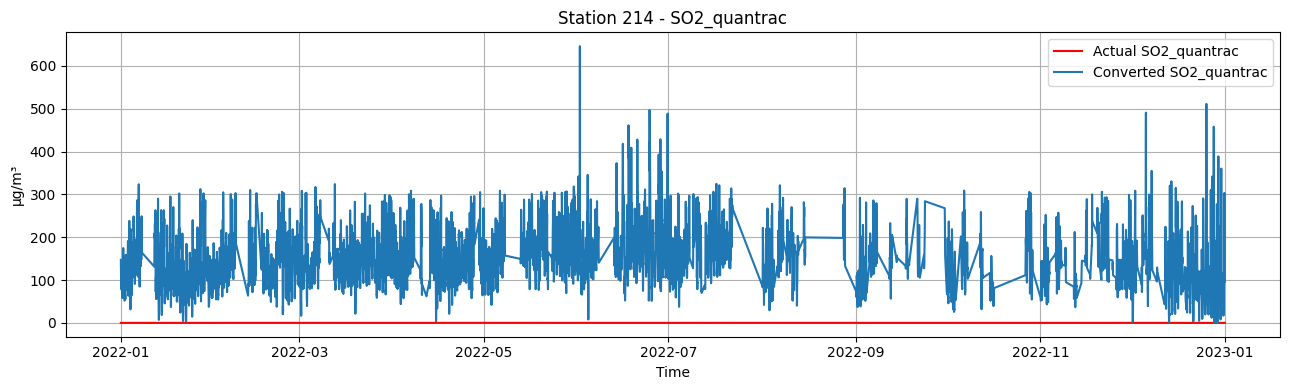

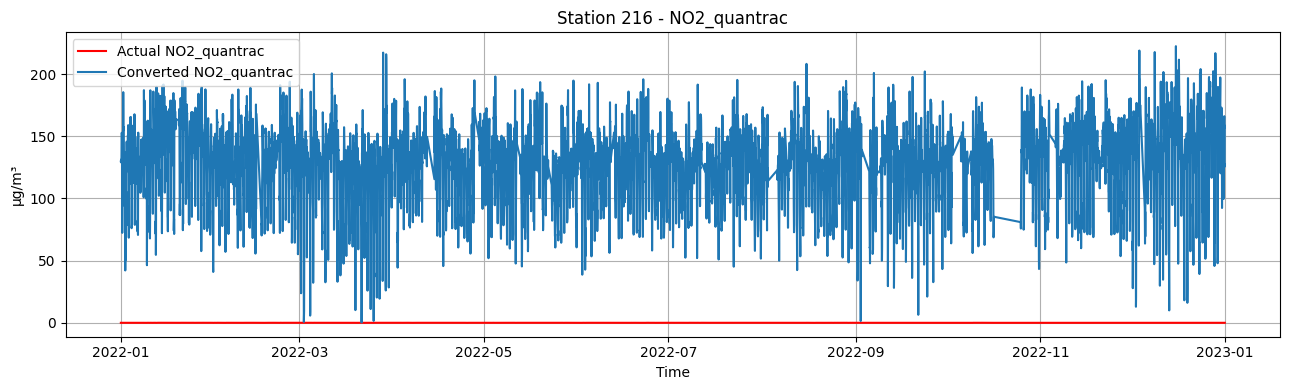

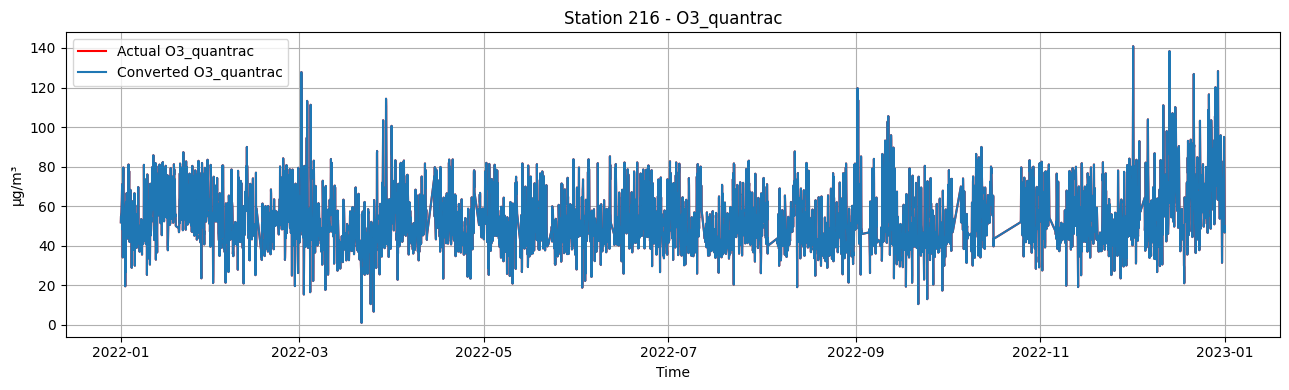

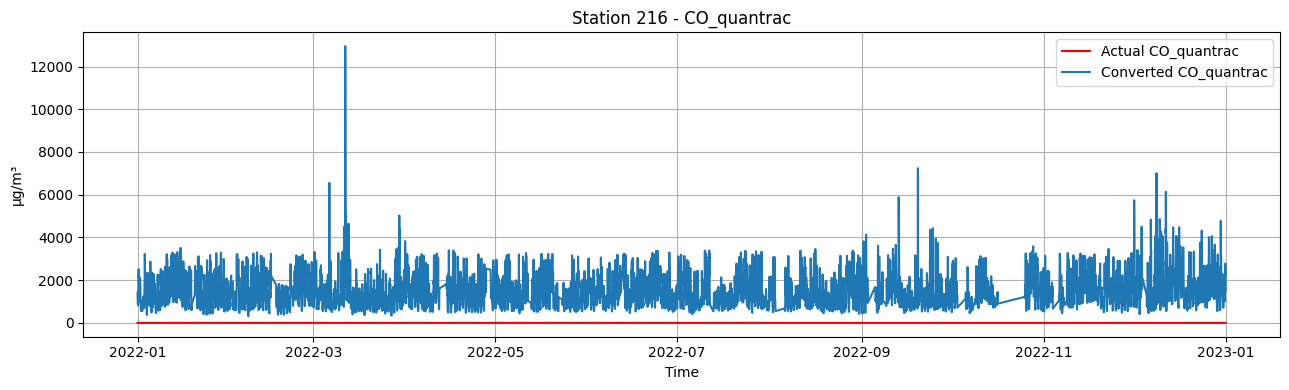

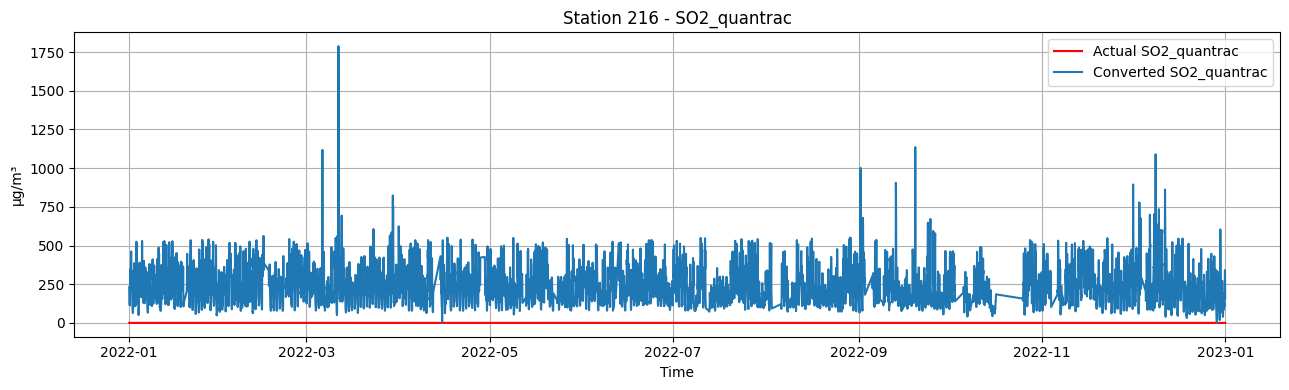

In [8]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    df_station_converted = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_2_data(df_station, target_col, f"Actual {target_col}",
                        df_station_converted, target_col, f"Converted {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Ugly hack to remove outliers

In [9]:
test = copy.deepcopy(df_converted)

lenbefore = len(test)
print(f"Before: {lenbefore} records")

# 214 SO2 quantrac
#test214 = test[test["station_id"] == 214]
#test = test.drop(index=test214[test214["SO2_quantrac"] > 120].index, errors="ignore")
#test = test.drop(index=test214[test214["O3_quantrac"] > 80].index, errors="ignore")

# 216 SO2 quantrac
test216 = test[test["station_id"] == 216]
#test = test.drop(index=test216[test216["SO2_quantrac"] > 700].index, errors="ignore")
test = test.drop(index=test216[test216["SO2_quantrac"] > 500].index, errors="ignore")
test = test.drop(index=test216[test216["O3_quantrac"] > 120].index, errors="ignore")

lenafter = len(test)
print(f"After: {lenafter} records")
print(f"Removed {lenbefore - lenafter} records")

df_converted = test.reset_index(drop=True)

Before: 13619 records
After: 13428 records
Removed 191 records


## Visualization after removing outliers

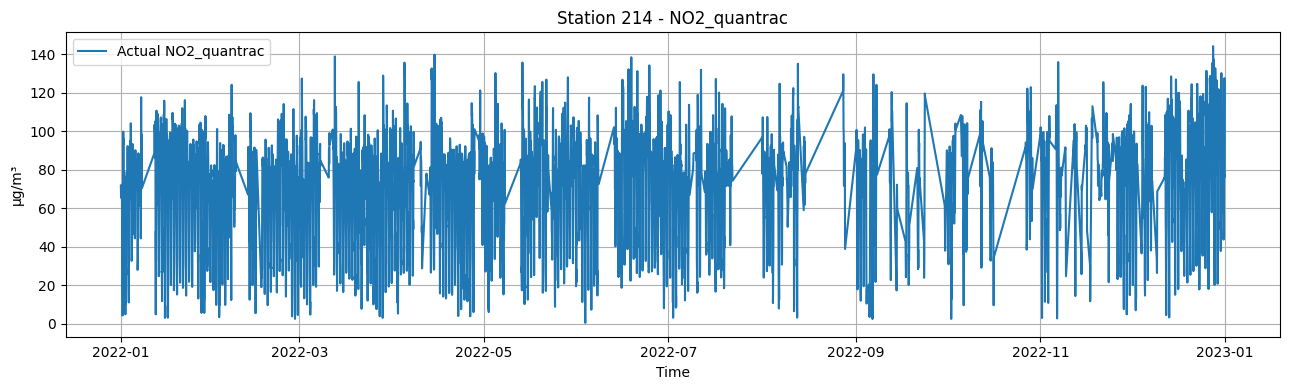

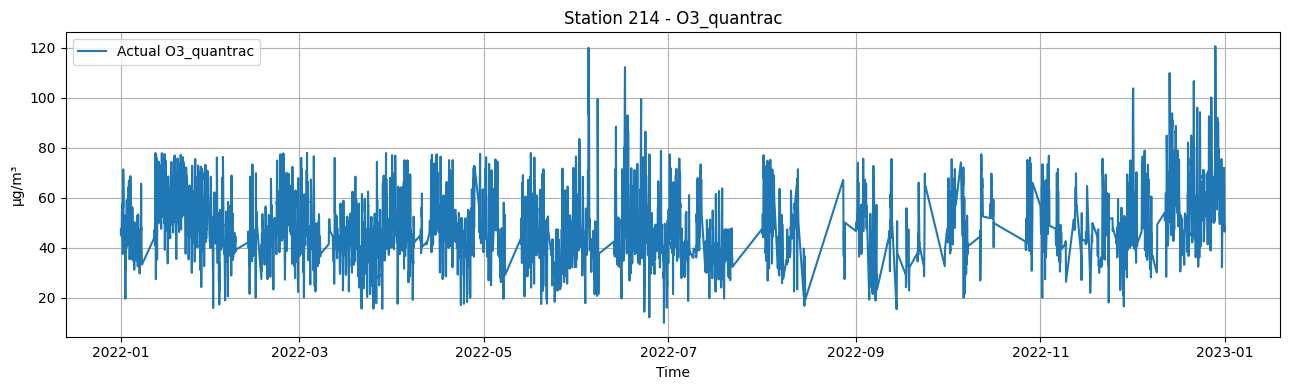

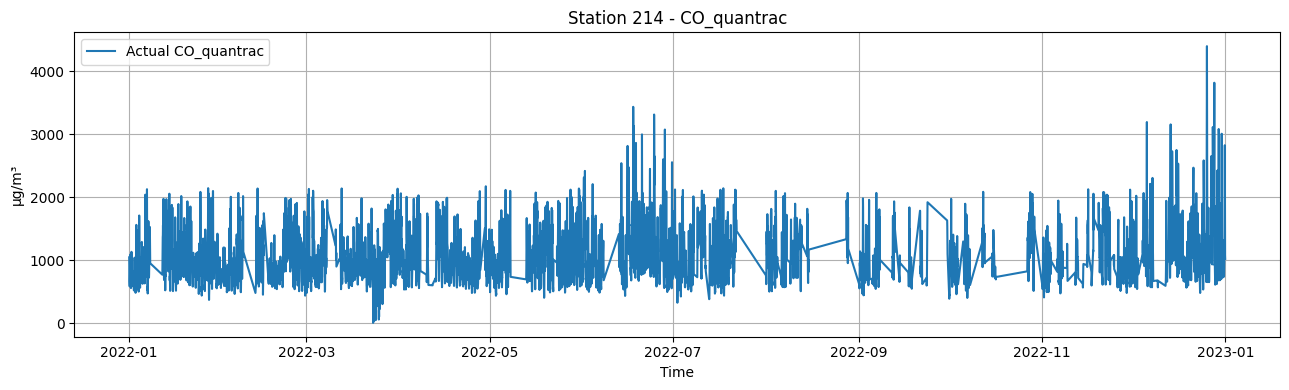

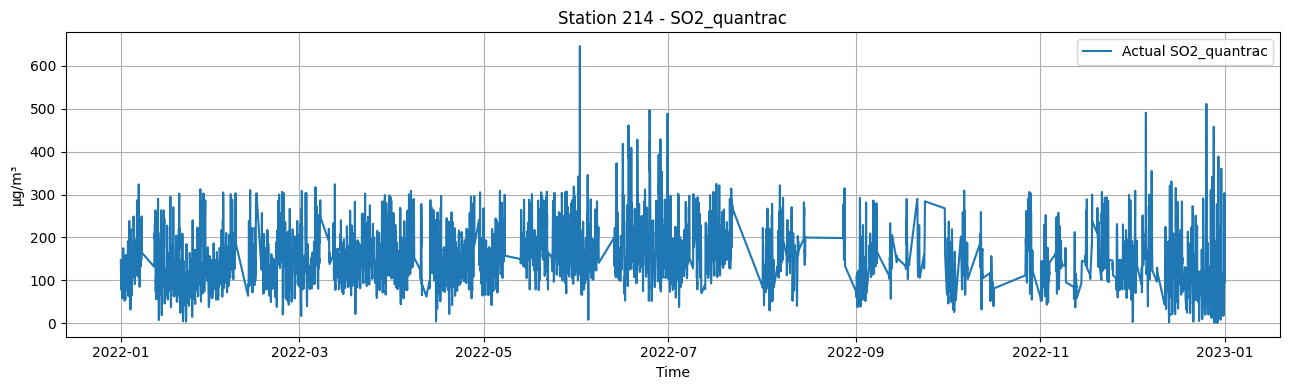

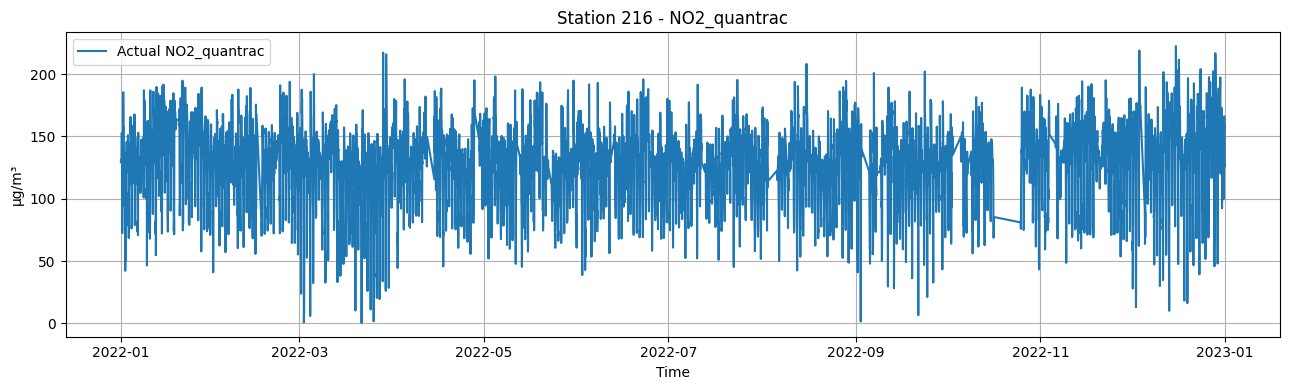

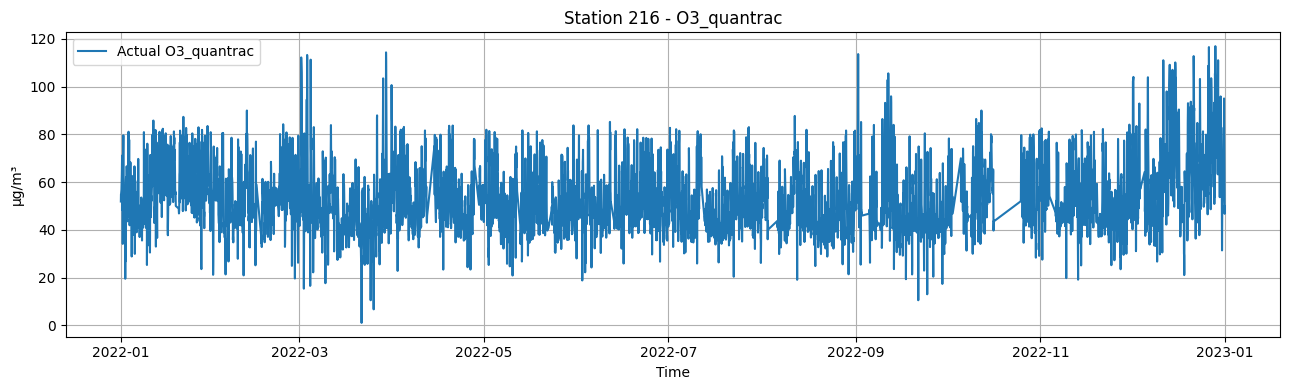

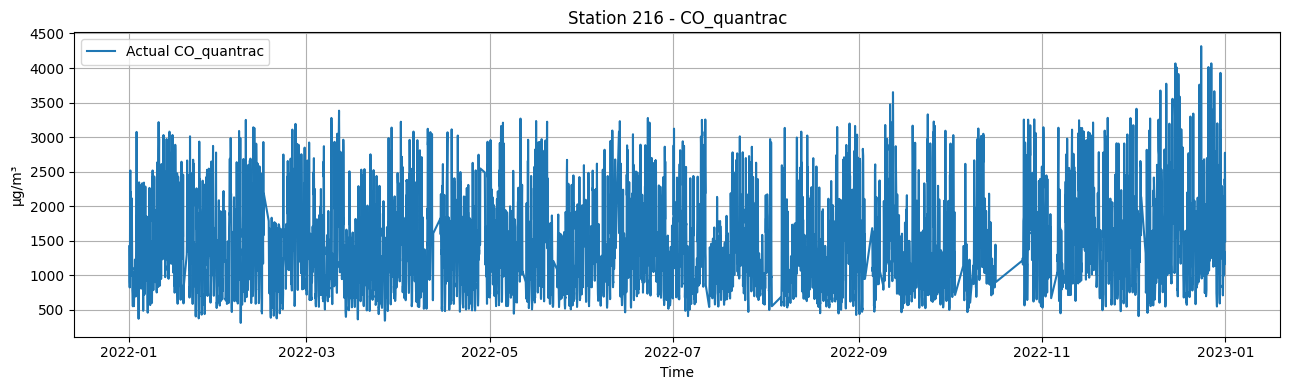

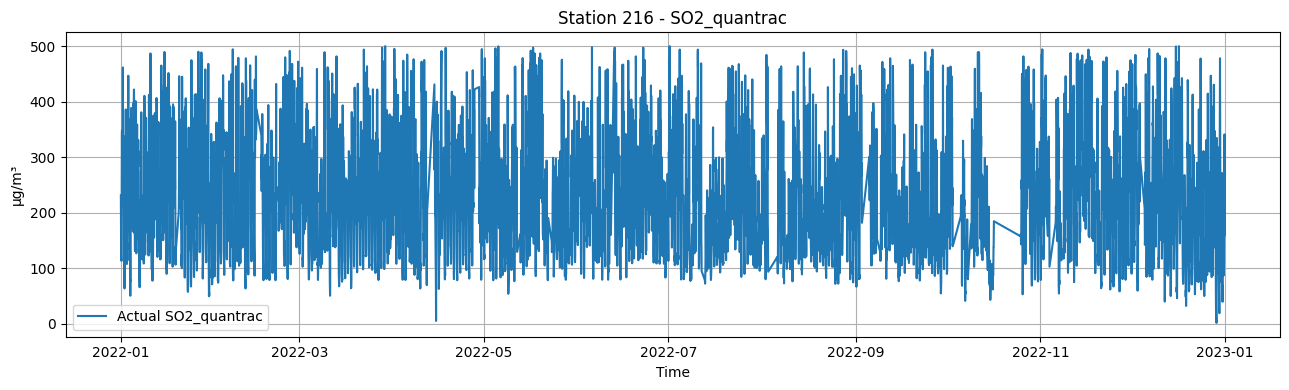

In [10]:
for station in STATION_IDS:
    df_station = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, f"Actual {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Feature engineering

### Time features

In [11]:
# Add time features and lag feature for all gases
dftestso2 = add_time_features(df_converted)
dftestso2 = add_lag_features(df_converted, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=LAG_STEPS)
dftestso2 = add_rolling_features(df_converted, group_col="station_id", target_cols=["SO2_quantrac"], windows=ROLL_WINDOWS)
print(dftestso2.shape)
print(dftestso2.columns)
dftestso2

(13428, 19)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'SO2_quantrac', 'station_id', 'SO2_quantrac_roll3_mean',
       'SO2_quantrac_roll3_std', 'SO2_quantrac_roll6_mean',
       'SO2_quantrac_roll6_std', 'SO2_quantrac_roll12_mean',
       'SO2_quantrac_roll12_std', 'SO2_quantrac_roll24_mean',
       'SO2_quantrac_roll24_std', 'SO2_quantrac_roll48_mean',
       'SO2_quantrac_roll48_std', 'SO2_quantrac_roll71_mean',
       'SO2_quantrac_roll71_std'],
      dtype='object')


date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0     2022-01-01 00:00:00     71.673644      27.601889    47.306123   
1     2022-01-01 01:00:00     68.360160      21.285000    44.916667   
2     2022-01-01 02:00:00     65.458637      18.414815    46.148148   
3     2022-01-01 03:00:00     67.122629      19.242857    46.357143   
4     2022-01-01 04:00:00     68.830960      18.140000    46.700000   
...                   ...           ...            ...          ...   
13423 2022-12-31 19:00:00    166.161013      41.450000    75.916667   
13424 2022-12-31 20:00:00    156.713627      50.530000    66.116667   
13425 2022-12-31 21:00:00    158.753760      55.055000    55.133333   
13426 2022-12-31 22:00:00    125.515280      26.078333    46.750000   
13427 2022-12-31 23:00:00    127.649573      21.161667    50.016667   

       CO_quantrac  SO2_quantrac  station_id  SO2_quantrac_roll3_mean  \
0      1044.063623    147.206555         214                      NaN   
1       771.223000    111.350000         214               147.206555   
2       661.746074     94.125926         214               129.278277   
3       621.729429     79.223810         214               117.560827   
4       581.427600     77.726667         214                94.899912   
...            ...           ...         ...                      ...   
13423  2393.562733    276.846667         216               135.803333   
13424  2301.054200    272.916667         216               187.912222   
13425  2773.918067    341.036667         216               243.223333   
13426  1698.984200    198.683333         216               296.933333   
13427  1492.177933    159.383333         216               270.878889   

       SO2_quantrac_roll3_std  SO2_quantrac_roll6_mean  \
0                         NaN                      NaN   
1                         NaN               147.206555   
2                   25.354413               129.278277   
3                   27.079865               117.560827   
4                   16.077074               107.976573   
...                       ...                      ...   
13423               38.789668               118.627778   
13424               85.214170               150.358889   
13425               54.869039               181.216667   
13426               38.245120               216.368333   
13427               71.198541               229.395556   

       SO2_quantrac_roll6_std  SO2_quantrac_roll12_mean  \
0                         NaN                       NaN   
1                         NaN                147.206555   
2                   25.354413                129.278277   
3                   27.079865                117.560827   
4                   29.262794                107.976573   
...                       ...                       ...   
13423               34.679875                136.640278   
13424               69.239785                150.831944   
13425               76.629713                161.603056   
13426               94.740668                173.902500   
13427               83.649956                175.030556   

       SO2_quantrac_roll12_std  SO2_quantrac_roll24_mean  \
0                          NaN                       NaN   
1                          NaN                147.206555   
2                    25.354413                129.278277   
3                    27.079865                117.560827   
4                    29.262794                107.976573   
...                        ...                       ...   
13423                37.994544                140.544545   
13424                54.116712                142.236628   
13425                64.438760                143.619406   
13426                82.596056                148.022462   
13427                82.855615                147.513017   

       SO2_quantrac_roll24_std  SO2_quantrac_roll48_mean  \
0                          NaN                       NaN   
1                          NaN              

### Station embedding

In [12]:
test_station_to_embedding, _ = learn_station_embeddings(dftestso2, target_col="SO2_quantrac", station_col="station_id", embed_dim=4)
print(test_station_to_embedding)

dftestso2, _ = attach_station_embedding(dftestso2, test_station_to_embedding, station_col="station_id")
display(dftestso2)

[Embed] epoch 001 | train MSE=44959.3726 | val MSE=44091.1112
[Embed] epoch 010 | train MSE=44164.8948 | val MSE=43258.8103
[Embed] epoch 020 | train MSE=41456.9737 | val MSE=40372.8821
[Embed] epoch 030 | train MSE=35992.2025 | val MSE=34777.4684
[Embed] epoch 040 | train MSE=28877.2127 | val MSE=27652.8644
[Embed] epoch 050 | train MSE=21672.0344 | val MSE=20548.5665
{214: [-3.2829216, -4.1803436, 4.157494, -3.935858], 216: [-4.7896767, -4.5424495, 6.1784797, -4.851963]}


date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0     2022-01-01 00:00:00     71.673644      27.601889    47.306123   
1     2022-01-01 01:00:00     68.360160      21.285000    44.916667   
2     2022-01-01 02:00:00     65.458637      18.414815    46.148148   
3     2022-01-01 03:00:00     67.122629      19.242857    46.357143   
4     2022-01-01 04:00:00     68.830960      18.140000    46.700000   
...                   ...           ...            ...          ...   
13423 2022-12-31 19:00:00    166.161013      41.450000    75.916667   
13424 2022-12-31 20:00:00    156.713627      50.530000    66.116667   
13425 2022-12-31 21:00:00    158.753760      55.055000    55.133333   
13426 2022-12-31 22:00:00    125.515280      26.078333    46.750000   
13427 2022-12-31 23:00:00    127.649573      21.161667    50.016667   

       CO_quantrac  SO2_quantrac  station_id  SO2_quantrac_roll3_mean  \
0      1044.063623    147.206555         214                      NaN   
1       771.223000    111.350000         214               147.206555   
2       661.746074     94.125926         214               129.278277   
3       621.729429     79.223810         214               117.560827   
4       581.427600     77.726667         214                94.899912   
...            ...           ...         ...                      ...   
13423  2393.562733    276.846667         216               135.803333   
13424  2301.054200    272.916667         216               187.912222   
13425  2773.918067    341.036667         216               243.223333   
13426  1698.984200    198.683333         216               296.933333   
13427  1492.177933    159.383333         216               270.878889   

       SO2_quantrac_roll3_std  SO2_quantrac_roll6_mean  ...  \
0                         NaN                      NaN  ...   
1                         NaN               147.206555  ...   
2                   25.354413               129.278277  ...   
3                   27.079865               117.560827  ...   
4                   16.077074               107.976573  ...   
...                       ...                      ...  ...   
13423               38.789668               118.627778  ...   
13424               85.214170               150.358889  ...   
13425               54.869039               181.216667  ...   
13426               38.245120               216.368333  ...   
13427               71.198541               229.395556  ...   

       SO2_quantrac_roll24_mean  SO2_quantrac_roll24_std  \
0                           NaN                      NaN   
1                    147.206555                      NaN   
2                    129.278277                25.354413   
3                    117.560827                27.079865   
4                    107.976573                29.262794   
...                         ...                      ...   
13423                140.544545                67.765013   
13424                142.236628                70.701701   
13425                143.619406                72.979219   
13426                148.022462                81.451124   
13427                147.513017                81.078068   

       SO2_quantrac_roll48_mean  SO2_quantrac_roll48_std  \
0                           NaN                      NaN   
1                    147.206555                      NaN   
2                    129.278277                25.354413   
3                    117.560827                27.079865   
4                    107.976573                29.262794   
...                         ...                      ...   
13423                163.518304               100.091609   
13424                163.381845                99.929030   
13425                163.427331                99.979419   
13426                163.918581               100.806853   
13427                161.453234                98.401243   

       SO2_quantrac_roll71_mean  SO2_quantrac_roll71_std  station_emb_0  \
0                

## Build supervised from time-series

In [13]:
# Example
Xdummy, ydummy = build_supervised_for_horizon(dftestso2, horizon_h=72, target_col="SO2_quantrac")
print("Horizon 1h:", Xdummy.shape, ydummy.shape)
print(Xdummy.columns)
print(ydummy.columns)
display(Xdummy)
display(ydummy)

Horizon 1h: (13282, 22) (13282, 3)
Index(['date', 'station_id', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac',
       'CO_quantrac', 'SO2_quantrac_roll3_mean', 'SO2_quantrac_roll3_std',
       'SO2_quantrac_roll6_mean', 'SO2_quantrac_roll6_std',
       'SO2_quantrac_roll12_mean', 'SO2_quantrac_roll12_std',
       'SO2_quantrac_roll24_mean', 'SO2_quantrac_roll24_std',
       'SO2_quantrac_roll48_mean', 'SO2_quantrac_roll48_std',
       'SO2_quantrac_roll71_mean', 'SO2_quantrac_roll71_std', 'station_emb_0',
       'station_emb_1', 'station_emb_2', 'station_emb_3'],
      dtype='object')
Index(['date', 'station_id', 'SO2_quantrac_t_plus_72h'], dtype='object')


date  station_id  NO2_quantrac  PM25_quantrac  \
0     2022-01-01 02:00:00         214     65.458637      18.414815   
1     2022-01-01 03:00:00         214     67.122629      19.242857   
2     2022-01-01 04:00:00         214     68.830960      18.140000   
3     2022-01-01 05:00:00         214     67.889360      18.091667   
4     2022-01-01 06:00:00         214     71.938240      23.813333   
...                   ...         ...           ...            ...   
13277 2022-12-28 14:00:00         216     97.486987      26.180000   
13278 2022-12-28 15:00:00         216     64.217120      24.885000   
13279 2022-12-28 16:00:00         216    135.935653      26.501667   
13280 2022-12-28 17:00:00         216    165.501893      29.516667   
13281 2022-12-28 18:00:00         216    176.204747      29.155000   

       O3_quantrac  CO_quantrac  SO2_quantrac_roll3_mean  \
0        46.148148   661.746074               129.278277   
1        46.357143   621.729429               117.560827   
2        46.700000   581.427600                94.899912   
3        46.100000   650.235600                83.692134   
4        47.233333   776.001333                78.371270   
...            ...          ...                      ...   
13277    69.450000  1612.974200               157.782222   
13278    53.883333  1670.314200               171.755556   
13279    82.800000  2611.454733               191.987778   
13280   105.483333  2638.404533               261.854444   
13281   102.333333  2795.898400               287.181111   

       SO2_quantrac_roll3_std  SO2_quantrac_roll6_mean  \
0                   25.354413               129.278277   
1                   27.079865               117.560827   
2                   16.077074               107.976573   
3                    9.066883               101.926591   
4                    0.769927                97.966048   
...                       ...                      ...   
13277               17.750021               230.196111   
13278               34.726212               192.933889   
13279               48.704159               188.640000   
13280               74.873161               209.818333   
13281               57.973702               229.468333   

       SO2_quantrac_roll6_std  ...  SO2_quantrac_roll24_mean  \
0                   25.354413  ...                129.278277   
1                   27.079865  ...                117.560827   
2                   29.262794  ...                107.976573   
3                   28.727072  ...                101.926591   
4                   27.464726  ...                 97.966048   
...                       ...  ...                       ...   
13277              107.084847  ...                225.260688   
13278               43.361169  ...                229.936660   
13279               36.449506  ...                236.086383   
13280               74.951515  ...                243.273188   
13281               76.312919  ...                243.600688   

       SO2_quantrac_roll24_std  SO2_quantrac_roll48_mean  \
0                    25.354413                129.278277   
1                    27.079865                117.560827   
2                    29.262794                107.976573   
3                    28.727072                101.926591   
4                    27.464726                 97.966048   
...                        ...                       ...   
13277                95.001320                211.166633   
13278                90.975128                213.504619   
13279                85.493261                215.251286   
13280                87.335532                219.718022   
13281                87.474695                221.364619   

       SO2_quantrac_roll48_std  SO2_quantrac_roll71_mean  \
0                    25.354413                129.278277   
1                    27.079865                117.560827   
2                    29.262794                107.976573   
3                    28.727072  

date  station_id  SO2_quantrac_t_plus_72h
0     2022-01-01 02:00:00         214                55.456667
1     2022-01-01 03:00:00         214                47.636364
2     2022-01-01 04:00:00         214                31.440000
3     2022-01-01 05:00:00         214                38.426667
4     2022-01-01 06:00:00         214                60.696667
...                   ...         ...                      ...
13277 2022-12-28 14:00:00         216               276.846667
13278 2022-12-28 15:00:00         216               272.916667
13279 2022-12-28 16:00:00         216               341.036667
13280 2022-12-28 17:00:00         216               198.683333
13281 2022-12-28 18:00:00         216               159.383333

[13282 rows x 3 columns]

## Split train/validation/test for each station

In [14]:
# Example
(X_train_dummy, y_train_dummy, meta_train_dummy,
 X_val_dummy, y_val_dummy, meta_val_dummy,
 X_test_dummy, y_test_dummy, meta_test_dummy) = train_test_validation_split(Xdummy, ydummy)
display(X_test_dummy)

NO2_quantrac  PM25_quantrac  O3_quantrac  CO_quantrac  \
4796      96.614886      24.628571    55.982143   933.131123   
4797     107.938747      26.735000    53.416667   886.788464   
4798      95.038827      25.981667    48.816667   986.316745   
4799      90.707467      22.166667    47.583333   814.228000   
4800      94.231064      29.032075    44.132075  1015.242566   
...             ...            ...          ...          ...   
13277     97.486987      26.180000    69.450000  1612.974200   
13278     64.217120      24.885000    53.883333  1670.314200   
13279    135.935653      26.501667    82.800000  2611.454733   
13280    165.501893      29.516667   105.483333  2638.404533   
13281    176.204747      29.155000   102.333333  2795.898400   

       SO2_quantrac_roll3_mean  SO2_quantrac_roll3_std  \
4796                108.800379               10.818052   
4797                109.694505               11.796273   
4798                115.558315                2.838758   
4799                124.616349               14.432711   
4800                138.860000               23.873330   
...                        ...                     ...   
13277               157.782222               17.750021   
13278               171.755556               34.726212   
13279               191.987778               48.704159   
13280               261.854444               74.873161   
13281               287.181111               57.973702   

       SO2_quantrac_roll6_mean  SO2_quantrac_roll6_std  \
4796                117.745967               14.711587   
4797                117.727253               14.709824   
4798                112.996697                8.429694   
4799                116.708364               14.323995   
4800                124.277253               23.212561   
...                        ...                     ...   
13277               230.196111              107.084847   
13278               192.933889               43.361169   
13279               188.640000               36.449506   
13280               209.818333               74.951515   
13281               229.468333               76.312919   

       SO2_quantrac_roll12_mean  SO2_quantrac_roll12_std  \
4796                  92.409916                29.446692   
4797                  96.932535                28.944585   
4798                 100.269916                28.352947   
4799                 106.346860                28.649114   
4800                 115.807971                26.290505   
...                         ...                      ...   
13277                243.141099                80.823043   
13278                240.618136                81.493228   
13279                239.366111                81.510768   
13280                241.403889                84.049560   
13281                243.114167                84.722566   

       SO2_quantrac_roll24_mean  SO2_quantrac_roll24_std  \
4796                  96.054475                41.376843   
4797                  93.862250                38.502560   
4798                  92.461277                37.046663   
4799                  93.461972                38.049850   
4800                  98.210722                39.172197   
...                         ...                      ...   
13277                225.260688                95.001320   
13278                229.936660                90.975128   
13279                236.086383                85.493261   
13280                243.273188                87.335532   
13281                243.600688                87.474695   

       SO2_quantrac_roll48_mean  SO2_quantrac_roll48_std  \
4796                 115.536160                50.047858   
4797                 115.592043                50.050059   
4798                 115.592043                50.050059   
4799                 116.783779                49.958877   
4800                 118.048293                50.314396   
...                         ...           

# LightGBM model

## Add time and lags features

In [15]:
# Add time features and lag feature for all gases
df_time_feats = add_time_features(df_converted)
df_lag_feats = add_lag_features(df_time_feats, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=LAG_STEPS)

## Training for SO2

In [16]:
target_col = "SO2_quantrac"

# Add rolling features for target_col
df_so2 = add_rolling_features(df_lag_feats, group_col="station_id", target_cols=[target_col], windows=ROLL_WINDOWS)

# Station embedding
so2_station_to_embedding, _ = learn_station_embeddings(df_so2, target_col=target_col, station_col="station_id", embed_dim=4)
df_so2, _ = attach_station_embedding(df_so2, so2_station_to_embedding, station_col="station_id")
print(so2_station_to_embedding)
with open(os.path.join(LIGHTGBM_DIR, f"{target_col}_station_embedding.pkl"), 'wb') as so2_emb_file:
    pickle.dump(so2_station_to_embedding, so2_emb_file)

# Start running model
so2_all_metrics = []
so2_models_by_h = {}
for h in HORIZONS:
    print(f"\n===== Training LightGBM for horizon = {h}h, target_col = {target_col} =====")
    model_h, metrics_overall, metrics_by_station, _ = train_lgbm_for_horizon(df_so2, horizon_h=h, target_col=target_col, calibrate=True)
    so2_models_by_h[h] = model_h
    model_h.save_model(os.path.join(LIGHTGBM_DIR, f"{target_col}_lightgbm_{h}h"))
    print("Overall test metrics:", metrics_overall)
    so2_all_metrics.append(metrics_by_station)

# Metrics table
so2_df_metrics_all = pd.concat(so2_all_metrics, ignore_index=True)
so2_df_metrics_all = so2_df_metrics_all.sort_values(["station", "horizon_h"]).reset_index(drop=True)
so2_df_metrics_all.to_csv(os.path.join(LIGHTGBM_DIR, f"{target_col}_metrics.csv"), index=False)
so2_df_metrics_all

[Embed] epoch 001 | train MSE=44959.3726 | val MSE=44091.1112
[Embed] epoch 010 | train MSE=44164.8948 | val MSE=43258.8103
[Embed] epoch 020 | train MSE=41456.9737 | val MSE=40372.8821
[Embed] epoch 030 | train MSE=35992.2025 | val MSE=34777.4684
[Embed] epoch 040 | train MSE=28877.2127 | val MSE=27652.8644
[Embed] epoch 050 | train MSE=21672.0344 | val MSE=20548.5665
{214: [-3.2829216, -4.1803436, 4.157494, -3.935858], 216: [-4.7896767, -4.5424495, 6.1784797, -4.851963]}

===== Training LightGBM for horizon = 1h, target_col = SO2_quantrac =====

X.shape = (13284, 55)
y.shape = (13284, 3)

Number of features: 55

Features:
date
station_id
NO2_quantrac
PM25_quantrac
O3_quantrac
CO_quantrac
hour
dayofweek
month
NO2_quantrac_lag3
NO2_quantrac_lag6
NO2_quantrac_lag12
NO2_quantrac_lag24
NO2_quantrac_lag48
NO2_quantrac_lag71
PM25_quantrac_lag3
PM25_quantrac_lag6
PM25_quantrac_lag12
PM25_quantrac_lag24
PM25_quantrac_lag48
PM25_quantrac_lag71
O3_quantrac_lag3
O3_quantrac_lag6
O3_quantrac_lag1

array([[122.94622175],
       [182.61119248],
       [160.58521031],
       ...,
       [315.36019124],
       [325.24847867],
       [268.8523468 ]])

[hiepdebug]  y_pred_corr...


array([[ 94.68842539],
       [158.70709679],
       [135.07389799],
       ...,
       [301.14267374],
       [311.75250084],
       [251.24119261]])

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([122.94622175, 182.61119248, 160.58521031, 143.42726754,
       137.9655827 , 125.61038717, 123.81860387, 118.07729901,
       109.78013284,  83.9776216 , 104.90628371, 103.09996372,
       115.44691951, 124.34213713, 146.4470705 , 142.81110242,
       128.41394009, 143.31276683, 118.54868413, 190.50734318,
       198.58013482, 209.68438405, 216.70036954, 220.76156799,
       222.48786539, 225.80330214, 229.05204516, 179.98505252,
       104.25491967, 116.52479667, 112.4390668 , 141.10734792,
       171.42294633, 257.26290889, 215.40828198, 233.52262376,
       229.99658031, 207.54313516, 246.38936823, 230.13345856,
       218.52216995, 203.1187354 , 183.44408595, 147.66901151,
       149.3457846 , 153.13375982, 147.29383674, 158.41476734,
       171.76362708, 203.04603558, 204.14728014, 217.14788986,
       176.96265258, 173.85671548, 148.76046625, 161.75799103,
       112.7070498 , 106.31814107, 125.1109942 , 241.67792318,
       262.78574064, 244.74323591, 238.81412488, 221.84

[hiepdebug]  y_pred_corr...


array([ 97.38556144, 163.35752206, 139.00324499, 120.03159193,
       113.99257016, 100.33134712,  98.35016024,  92.00196072,
        82.82772812,  54.29771738,  77.43868026,  75.44142006,
        89.09353237,  98.92903449, 123.37060843, 119.350294  ,
       103.43125449, 119.90498773,  92.52317443, 172.08834916,
       181.01448934, 193.29253261, 201.0501551 , 205.54064961,
       207.4494283 , 211.11532908, 214.70748616, 160.45378139,
        76.71846264,  90.28534842,  85.76772933, 117.46644116,
       150.98660283, 245.90042848, 199.62148516, 219.65063507,
       215.75186504, 190.92493927, 233.87748123, 215.90321225,
       203.0645321 , 186.03285061, 164.27845799, 124.72171686,
       126.57573617, 130.76412593, 124.30688358, 136.60337156,
       151.36329582, 185.95246593, 187.17011947, 201.54498134,
       157.11189339, 153.67763779, 125.92854572, 140.29999655,
        86.06403995,  78.99978047,  99.77916495, 228.66800465,
       252.0070608 , 232.05734161, 225.50148355, 206.74

sid = 214, grp =                     date  station_id      y_true      y_pred
4798 2022-11-12 15:00:00         214   80.346667  122.946222
4799 2022-11-12 16:00:00         214  115.560714  182.611192
4800 2022-11-12 17:00:00         214   91.263333  160.585210
4801 2022-11-12 18:00:00         214  104.800000  143.427268
4802 2022-11-12 19:00:00         214  101.743333  137.965583
...                  ...         ...         ...         ...
5640 2022-12-31 18:00:00         214  210.473333  195.685854
5641 2022-12-31 19:00:00         214  303.483333  212.571529
5642 2022-12-31 20:00:00         214  190.505085  272.487495
5643 2022-12-31 21:00:00         214  119.706897  195.742535
5644 2022-12-31 22:00:00         214   95.630000  140.060242

[847 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 11, 17), datetime.date(2022, 11, 18), datetime.da

date      target
0   2022-11-16  223.575224
1   2022-11-20  159.857155
2   2022-11-21  195.820442
3   2022-11-22  197.489861
4   2022-11-23  141.902652
5   2022-11-26  129.505649
6   2022-11-27  117.033831
7   2022-11-28  135.423575
8   2022-11-29  130.103747
9   2022-11-30  154.533602
10  2022-12-01   88.130236
11  2022-12-02  155.230725
12  2022-12-04  151.904682
13  2022-12-05  229.706337
14  2022-12-06  150.307900
15  2022-12-07  166.009742
16  2022-12-12   94.516636
17  2022-12-13  110.461093
18  2022-12-14  134.850578
19  2022-12-15  138.268681
20  2022-12-16  120.390261
21  2022-12-17  153.442916
22  2022-12-18   92.962689
23  2022-12-19   83.335549
24  2022-12-20  105.314717
25  2022-12-21  109.232604
26  2022-12-22  118.848396
27  2022-12-23   72.683848
28  2022-12-24  107.435595
29  2022-12-25  130.106352
30  2022-12-26   88.126303
31  2022-12-27  143.580159
32  2022-12-28  127.205374
33  2022-12-29  104.974147
34  2022-12-30  103.028162
35  2022-12-31   90.363865

date      target
0   2022-11-16  192.396879
1   2022-11-20  171.195993
2   2022-11-21  196.451007
3   2022-11-22  187.216578
4   2022-11-23  158.842184
5   2022-11-26  142.396388
6   2022-11-27  126.871929
7   2022-11-28  140.408201
8   2022-11-29  140.926106
9   2022-11-30  144.420357
10  2022-12-01  131.160216
11  2022-12-02  139.446053
12  2022-12-04  155.080367
13  2022-12-05  190.877313
14  2022-12-06  164.540303
15  2022-12-07  165.904017
16  2022-12-12  140.853257
17  2022-12-13  161.427609
18  2022-12-14  160.500211
19  2022-12-15  165.789548
20  2022-12-16  152.233903
21  2022-12-17  163.000952
22  2022-12-18  118.775591
23  2022-12-19  125.731055
24  2022-12-20  136.649065
25  2022-12-21  146.735133
26  2022-12-22  136.265634
27  2022-12-23  125.654723
28  2022-12-24  146.972185
29  2022-12-25  152.157178
30  2022-12-26  138.283654
31  2022-12-27  194.425036
32  2022-12-28  182.927241
33  2022-12-29  146.512784
34  2022-12-30  136.822344
35  2022-12-31  134.287910

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([229.3201176 , 360.77741069, 307.10736325, ..., 315.36019124,
       325.24847867, 268.8523468 ])

[hiepdebug]  y_pred_corr...


array([205.63537105, 351.20556113, 291.77364356, ..., 300.91247268,
       311.86233972, 249.41167272])

sid = 216, grp =                      date  station_id      y_true      y_pred
12138 2022-11-10 15:00:00         216  348.460000  229.320118
12139 2022-11-10 16:00:00         216  234.443664  360.777411
12140 2022-11-10 17:00:00         216  386.450000  307.107363
12141 2022-11-10 18:00:00         216  324.006667  340.476456
12142 2022-11-10 19:00:00         216  387.323333  345.150847
...                   ...         ...         ...         ...
13279 2022-12-31 18:00:00         216  276.846667  301.886267
13280 2022-12-31 19:00:00         216  272.916667  320.132527
13281 2022-12-31 20:00:00         216  341.036667  315.360191
13282 2022-12-31 21:00:00         216  198.683333  325.248479
13283 2022-12-31 22:00:00         216  159.383333  268.852347

[1146 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16)

date      target
0   2022-11-11  282.849348
1   2022-11-12  171.483669
2   2022-11-13  311.931392
3   2022-11-14  339.929333
4   2022-11-15  249.735915
5   2022-11-16  303.894916
6   2022-11-17  339.099789
7   2022-11-18  229.771129
8   2022-11-19  227.711133
9   2022-11-20  155.233974
10  2022-11-21  255.505270
11  2022-11-22  267.948398
12  2022-11-23  212.779880
13  2022-11-24  175.573590
14  2022-11-25  210.766161
15  2022-11-26  254.735467
16  2022-11-27  183.120561
17  2022-11-28  242.814531
18  2022-11-29  223.025097
19  2022-11-30  274.780862
20  2022-12-01  228.518524
21  2022-12-02  312.131968
22  2022-12-03  210.772224
23  2022-12-05  222.800769
24  2022-12-06  248.161251
25  2022-12-07  148.903762
26  2022-12-08  239.248019
27  2022-12-09  266.631230
28  2022-12-10  208.065075
29  2022-12-11  207.323566
30  2022-12-12  216.624638
31  2022-12-13  174.433220
32  2022-12-14  198.248735
33  2022-12-15  234.183784
34  2022-12-16  263.583099
35  2022-12-17  286.360197
36  2022-12-18  157.076072
37  2022-12-19  170.565941
38  2022-12-20  159.879389
39  2022-12-21  197.864807
40  2022-12-22  147.810267
41  2022-12-23  219.805396
42  2022-12-24  156.390519
43  2022-12-25  136.331795
44  2022-12-26  176.860251
45  2022-12-27  226.110911
46  2022-12-28  229.491878
47  2022-12-29  168.865238
48  2022-12-30  182.221862
49  2022-12-31  141.643004

date      target
0   2022-11-11  258.085936
1   2022-11-12  223.158298
2   2022-11-13  276.802203
3   2022-11-14  290.467040
4   2022-11-15  255.604496
5   2022-11-16  291.256218
6   2022-11-17  291.327269
7   2022-11-18  255.278713
8   2022-11-19  253.467566
9   2022-11-20  206.795873
10  2022-11-21  248.113004
11  2022-11-22  253.549712
12  2022-11-23  256.949530
13  2022-11-24  218.212265
14  2022-11-25  226.251437
15  2022-11-26  260.443827
16  2022-11-27  212.446881
17  2022-11-28  241.828002
18  2022-11-29  233.755002
19  2022-11-30  262.066021
20  2022-12-01  235.006849
21  2022-12-02  264.995522
22  2022-12-03  221.312744
23  2022-12-05  227.892583
24  2022-12-06  246.103591
25  2022-12-07  192.432364
26  2022-12-08  231.954745
27  2022-12-09  256.350526
28  2022-12-10  239.668492
29  2022-12-11  230.963971
30  2022-12-12  250.002988
31  2022-12-13  242.194093
32  2022-12-14  242.346507
33  2022-12-15  263.242530
34  2022-12-16  253.682921
35  2022-12-17  290.381056
36  2022-12-18  215.928611
37  2022-12-19  207.173759
38  2022-12-20  212.180592
39  2022-12-21  237.219435
40  2022-12-22  203.215569
41  2022-12-23  254.257506
42  2022-12-24  239.793631
43  2022-12-25  205.788246
44  2022-12-26  240.887303
45  2022-12-27  276.105583
46  2022-12-28  273.455294
47  2022-12-29  215.963157
48  2022-12-30  237.467118
49  2022-12-31  221.807181

Overall test metrics: {'rmse': 65.94, 'mae': 51.66, 'mape': 82.67, 'mnbe': -41.9, 'r': 0.81, 'n_samples': 1993}

===== Training LightGBM for horizon = 24h, target_col = SO2_quantrac =====

X.shape = (13238, 55)
y.shape = (13238, 3)

Number of features: 55

Features:
date
station_id
NO2_quantrac
PM25_quantrac
O3_quantrac
CO_quantrac
hour
dayofweek
month
NO2_quantrac_lag3
NO2_quantrac_lag6
NO2_quantrac_lag12
NO2_quantrac_lag24
NO2_quantrac_lag48
NO2_quantrac_lag71
PM25_quantrac_lag3
PM25_quantrac_lag6
PM25_quantrac_lag12
PM25_quantrac_lag24
PM25_quantrac_lag48
PM25_quantrac_lag71
O3_quantrac_lag3
O3_quantrac_lag6
O3_quantrac_lag12
O3_quantrac_lag24
O3_quantrac_lag48
O3_quantrac_lag71
CO_quantrac_lag3
CO_quantrac_lag6
CO_quantrac_lag12
CO_quantrac_lag24
CO_quantrac_lag48
CO_quantrac_lag71
SO2_quantrac_lag3
SO2_quantrac_lag6
SO2_quantrac_lag12
SO2_quantrac_lag24
SO2_quantrac_lag48
SO2_quantrac_lag71
SO2_quantrac_roll3_mean
SO2_quantrac_roll3_std
SO2_quantrac_roll6_mean
SO2_quantrac_roll6_s

array([[156.54598589],
       [163.57565015],
       [169.89598906],
       ...,
       [245.45789688],
       [230.49726969],
       [229.15841876]])

[hiepdebug]  y_pred_corr...


array([[131.09145811],
       [139.40055661],
       [146.871229  ],
       ...,
       [236.18578412],
       [218.50224754],
       [216.919719  ]])

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([156.54598589, 163.57565015, 169.89598906, 172.51762241,
       159.64595293, 146.34656898, 158.35793869, 148.81565683,
       144.28124512, 137.54262585, 151.56048571, 166.69912991,
       188.32095639, 188.00198551, 190.53092697, 168.80970192,
       142.0448852 , 142.31035097, 137.92215124, 139.59208251,
       146.70295668, 155.18265363, 167.73300312, 159.70967027,
       164.94495473, 170.36827635, 166.96993035, 157.93066255,
       164.59247327, 142.23359395, 135.22803694, 131.08442722,
       137.34264445, 145.93969267, 161.66488396, 175.141872  ,
       189.97306688, 187.04826976, 168.84479525, 159.39231865,
       157.36005431, 165.340062  , 168.56554717, 170.52027779,
       154.03709388, 156.40181455, 174.95765781, 154.50956235,
       143.58269581, 148.0574574 , 134.4002877 , 144.53685251,
       137.76187469, 142.25648376, 159.27009474, 163.92124384,
       174.98233626, 182.40433748, 182.61918885, 178.39974749,
       180.41208183, 187.71682003, 163.30958524, 151.62

[hiepdebug]  y_pred_corr...


array([120.40800413, 129.03250258, 136.78674961, 140.00315825,
       124.21126698, 107.8946248 , 122.63103833, 110.92387962,
       105.36073671,  97.09331321, 114.29143339, 132.86461254,
       159.39182669, 159.00049024, 162.10317778, 135.45401431,
       102.61700928, 102.94270181,  97.5589423 ,  99.60773426,
       108.33186689, 118.7353699 , 134.13304267, 124.28944   ,
       130.71246407, 137.36618568, 133.19685002, 122.10682519,
       130.28001443, 102.84853076,  94.25360882,  89.16992995,
        96.84796163, 107.39543963, 126.688237  , 143.22277667,
       161.41875483, 157.83040306, 135.49706934, 123.90009017,
       121.4067619 , 131.19721013, 135.15446768, 137.552672  ,
       117.32991469, 120.23112433, 142.99676943, 117.90957304,
       104.50370611, 109.99366594,  93.23806642, 105.67433427,
        97.36230348, 102.87661363, 123.75013707, 129.45650181,
       143.02704673, 152.13289243, 152.39648757, 147.21977299,
       149.6886497 , 158.65062869, 128.70607499, 114.37

sid = 214, grp =                     date  station_id      y_true      y_pred
4778 2022-11-09 06:00:00         214  104.800000  156.545986
4779 2022-11-09 07:00:00         214  101.743333  163.575650
4780 2022-11-09 08:00:00         214   83.840000  169.895989
4781 2022-11-09 09:00:00         214   87.333333  172.517622
4782 2022-11-09 10:00:00         214   83.840000  159.645953
...                  ...         ...         ...         ...
5617 2022-12-30 19:00:00         214  210.473333  185.755400
5618 2022-12-30 20:00:00         214  303.483333  237.553617
5619 2022-12-30 21:00:00         214  190.505085  171.160012
5620 2022-12-30 22:00:00         214  119.706897  162.583276
5621 2022-12-30 23:00:00         214   95.630000  158.082575

[844 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 9), datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 11, 17), datetime.dat

date      target
0   2022-11-12  178.463980
1   2022-11-16  169.209308
2   2022-11-20  187.045223
3   2022-11-21  200.323901
4   2022-11-22  137.576681
5   2022-11-23  126.046888
6   2022-11-26  117.006004
7   2022-11-27  136.023992
8   2022-11-28  129.048469
9   2022-11-29  153.532907
10  2022-11-30   90.750236
11  2022-12-01  152.901836
12  2022-12-02  186.483297
13  2022-12-04  147.225965
14  2022-12-05  155.999370
15  2022-12-06  170.423052
16  2022-12-07   95.659241
17  2022-12-12  111.922300
18  2022-12-13  132.812800
19  2022-12-14  139.906181
20  2022-12-15  119.225817
21  2022-12-16  153.970555
22  2022-12-17   94.800328
23  2022-12-18   80.260688
24  2022-12-19  106.078884
25  2022-12-20  111.124827
26  2022-12-21  118.357146
27  2022-12-22   72.228987
28  2022-12-23  106.816984
29  2022-12-24  130.688574
30  2022-12-25   87.987444
31  2022-12-26  146.311688
32  2022-12-27  132.117874
33  2022-12-28  104.246369
34  2022-12-29  101.590801
35  2022-12-30   89.910092

date      target
0   2022-11-12  159.083683
1   2022-11-16  161.228353
2   2022-11-20  161.515832
3   2022-11-21  170.897994
4   2022-11-22  176.958240
5   2022-11-23  166.198051
6   2022-11-26  166.144426
7   2022-11-27  167.912465
8   2022-11-28  168.240870
9   2022-11-29  172.971941
10  2022-11-30  162.909166
11  2022-12-01  157.667182
12  2022-12-02  152.773111
13  2022-12-04  161.081704
14  2022-12-05  168.655723
15  2022-12-06  169.573922
16  2022-12-07  167.643873
17  2022-12-12  160.508375
18  2022-12-13  158.513874
19  2022-12-14  166.480735
20  2022-12-15  150.792001
21  2022-12-16  161.507901
22  2022-12-17  162.409721
23  2022-12-18  168.628524
24  2022-12-19  169.977032
25  2022-12-20  168.039782
26  2022-12-21  165.276036
27  2022-12-22  155.042985
28  2022-12-23  153.108017
29  2022-12-24  156.306449
30  2022-12-25  152.559927
31  2022-12-26  165.754676
32  2022-12-27  182.624631
33  2022-12-28  180.125774
34  2022-12-29  162.122697
35  2022-12-30  151.964154

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([297.70876736, 261.54993254, 271.56907152, ..., 245.45789688,
       230.49726969, 229.15841876])

[hiepdebug]  y_pred_corr...


array([286.94105793, 253.66572287, 262.88588188, ..., 238.85695259,
       225.08936619, 223.85728242])

sid = 216, grp =                      date  station_id      y_true      y_pred
12095 2022-11-09 19:00:00         216  324.006667  297.708767
12096 2022-11-09 20:00:00         216  387.323333  261.549933
12097 2022-11-09 21:00:00         216  487.756667  271.569072
12098 2022-11-09 22:00:00         216  213.530000  239.428255
12099 2022-11-09 23:00:00         216  206.139623  222.546001
...                   ...         ...         ...         ...
13233 2022-12-30 19:00:00         216  276.846667  252.033153
13234 2022-12-30 20:00:00         216  272.916667  240.851415
13235 2022-12-30 21:00:00         216  341.036667  245.457897
13236 2022-12-30 22:00:00         216  198.683333  230.497270
13237 2022-12-30 23:00:00         216  159.383333  229.158419

[1143 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15),

date      target
0   2022-11-10  286.336154
1   2022-11-11  174.401944
2   2022-11-12  310.184725
3   2022-11-13  331.860749
4   2022-11-14  249.772259
5   2022-11-15  307.697555
6   2022-11-16  331.257983
7   2022-11-17  236.539462
8   2022-11-18  225.782522
9   2022-11-19  160.601335
10  2022-11-20  249.955964
11  2022-11-21  266.536104
12  2022-11-22  217.075962
13  2022-11-23  173.006774
14  2022-11-24  212.183820
15  2022-11-25  255.536023
16  2022-11-26  183.448061
17  2022-11-27  243.378558
18  2022-11-28  223.607319
19  2022-11-29  270.850862
20  2022-11-30  215.049550
21  2022-12-01  352.321053
22  2022-12-02  206.246576
23  2022-12-03  226.705287
24  2022-12-05  254.592627
25  2022-12-06  147.846140
26  2022-12-07  225.206803
27  2022-12-08  252.361751
28  2022-12-09  229.389147
29  2022-12-10  185.015667
30  2022-12-11  242.219000
31  2022-12-12  169.226483
32  2022-12-13  201.066275
33  2022-12-14  246.121212
34  2022-12-15  256.312137
35  2022-12-16  286.360197
36  2022-12-17  160.943727
37  2022-12-18  166.297360
38  2022-12-19  162.843711
39  2022-12-20  193.441274
40  2022-12-21  146.509699
41  2022-12-22  220.494009
42  2022-12-23  155.374405
43  2022-12-24  135.440267
44  2022-12-25  175.277334
45  2022-12-26  232.697300
46  2022-12-27  223.550410
47  2022-12-28  158.338094
48  2022-12-29  195.023651
49  2022-12-30  141.643004

date      target
0   2022-11-10  212.230547
1   2022-11-11  227.354355
2   2022-11-12  222.162046
3   2022-11-13  229.646898
4   2022-11-14  238.998926
5   2022-11-15  236.388158
6   2022-11-16  231.574611
7   2022-11-17  235.259960
8   2022-11-18  239.682169
9   2022-11-19  225.932691
10  2022-11-20  213.319955
11  2022-11-21  236.841442
12  2022-11-22  239.784605
13  2022-11-23  247.870637
14  2022-11-24  226.252258
15  2022-11-25  225.344891
16  2022-11-26  226.971240
17  2022-11-27  237.487026
18  2022-11-28  242.590411
19  2022-11-29  241.473876
20  2022-11-30  228.551725
21  2022-12-01  218.112736
22  2022-12-02  214.498219
23  2022-12-03  210.995240
24  2022-12-05  216.220875
25  2022-12-06  223.940479
26  2022-12-07  216.760362
27  2022-12-08  199.701867
28  2022-12-09  216.770914
29  2022-12-10  218.616465
30  2022-12-11  213.658512
31  2022-12-12  220.371110
32  2022-12-13  224.107523
33  2022-12-14  226.205423
34  2022-12-15  232.479244
35  2022-12-16  224.505802
36  2022-12-17  233.433094
37  2022-12-18  230.497749
38  2022-12-19  230.368438
39  2022-12-20  220.360433
40  2022-12-21  231.059856
41  2022-12-22  206.760349
42  2022-12-23  213.825028
43  2022-12-24  221.408841
44  2022-12-25  207.249705
45  2022-12-26  229.731785
46  2022-12-27  242.543211
47  2022-12-28  236.244203
48  2022-12-29  221.129735
49  2022-12-30  227.211228

Overall test metrics: {'rmse': 90.11, 'mae': 72.46, 'mape': 127.1, 'mnbe': -84.73, 'r': 0.55, 'n_samples': 1987}

===== Training LightGBM for horizon = 48h, target_col = SO2_quantrac =====

X.shape = (13190, 55)
y.shape = (13190, 3)

Number of features: 55

Features:
date
station_id
NO2_quantrac
PM25_quantrac
O3_quantrac
CO_quantrac
hour
dayofweek
month
NO2_quantrac_lag3
NO2_quantrac_lag6
NO2_quantrac_lag12
NO2_quantrac_lag24
NO2_quantrac_lag48
NO2_quantrac_lag71
PM25_quantrac_lag3
PM25_quantrac_lag6
PM25_quantrac_lag12
PM25_quantrac_lag24
PM25_quantrac_lag48
PM25_quantrac_lag71
O3_quantrac_lag3
O3_quantrac_lag6
O3_quantrac_lag12
O3_quantrac_lag24
O3_quantrac_lag48
O3_quantrac_lag71
CO_quantrac_lag3
CO_quantrac_lag6
CO_quantrac_lag12
CO_quantrac_lag24
CO_quantrac_lag48
CO_quantrac_lag71
SO2_quantrac_lag3
SO2_quantrac_lag6
SO2_quantrac_lag12
SO2_quantrac_lag24
SO2_quantrac_lag48
SO2_quantrac_lag71
SO2_quantrac_roll3_mean
SO2_quantrac_roll3_std
SO2_quantrac_roll6_mean
SO2_quantrac_roll6_

array([[156.00295255],
       [166.36200166],
       [186.19994731],
       ...,
       [198.71891019],
       [188.24692719],
       [188.13464512]])

[hiepdebug]  y_pred_corr...


array([[133.28370926],
       [145.82828795],
       [169.8516001 ],
       ...,
       [185.01178647],
       [172.33044733],
       [172.19447624]])

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([156.00295255, 166.36200166, 186.19994731, 189.64628405,
       228.47671413, 204.00034208, 169.42930624, 171.72002989,
       169.53242006, 169.55248245, 171.9732727 , 178.06458173,
       183.70188638, 193.26796206, 197.40436859, 192.83021365,
       197.28777531, 181.91011026, 178.62615854, 135.52633981,
       162.07221419, 179.19824064, 183.06118221, 178.70368855,
       171.8208457 , 161.75118999, 147.57669536, 143.78189027,
       142.91300832, 136.23849287, 147.79066099, 148.52442733,
       183.00473841, 172.13173516, 159.8528505 , 155.45502781,
       138.82270512, 144.0447065 , 141.46051287, 144.65480779,
       150.12927693, 160.7219017 , 180.21279618, 178.44472674,
       175.06906075, 182.04872001, 175.73126177, 178.16544653,
       161.98867234, 145.93828262, 165.27824995, 166.41186054,
       176.53685133, 171.08833457, 182.73830625, 193.57497506,
       202.67142503, 197.40051093, 178.36723805, 183.28280856,
       172.36201005, 163.92218401, 166.92553322, 166.94

[hiepdebug]  y_pred_corr...


array([120.51627894, 126.10641585, 136.81172587, 138.67150026,
       159.62587729, 146.41749594, 127.76165007, 128.99781168,
       127.81729421, 127.82812064, 129.13447113, 132.42157317,
       135.46367718, 140.62589547, 142.85805777, 140.38966978,
       142.7951396 , 134.49676663, 132.72462138, 109.46631985,
       123.79148337, 133.03333864, 135.11792884, 132.76645952,
       129.05221573, 123.6182465 , 115.96915005, 113.92132889,
       113.45244714, 109.85062473, 116.08461405, 116.48058227,
       135.08746962, 129.2199835 , 122.5938303 , 120.2205979 ,
       111.24516395, 114.06315452, 112.66862535, 114.39238839,
       117.34662016, 123.06280339, 133.5808314 , 132.62671388,
       130.80507611, 134.57156573, 131.16242497, 132.47600365,
       123.746401  , 115.08500022, 125.5215822 , 126.1333216 ,
       131.59715174, 128.65692486, 134.9436927 , 140.79157137,
       145.70036176, 142.85597603, 132.58489804, 135.23752685,
       129.34424859, 124.78979745, 126.41051891, 126.42

sid = 214, grp =                     date  station_id      y_true      y_pred
4758 2022-11-07 05:00:00         214   83.840000  156.002953
4759 2022-11-07 06:00:00         214   58.076667  166.362002
4760 2022-11-07 07:00:00         214   92.947619  186.199947
4761 2022-11-07 08:00:00         214  109.603333  189.646284
4762 2022-11-07 09:00:00         214  116.590000  228.476714
...                  ...         ...         ...         ...
5593 2022-12-29 19:00:00         214  210.473333  209.230913
5594 2022-12-29 20:00:00         214  303.483333  220.249255
5595 2022-12-29 21:00:00         214  190.505085  191.900798
5596 2022-12-29 22:00:00         214  119.706897  174.048707
5597 2022-12-29 23:00:00         214   95.630000  165.256712

[840 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 7), datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(

date      target
0   2022-11-07  172.672978
1   2022-11-12  185.283196
2   2022-11-16  177.351021
3   2022-11-20  192.637922
4   2022-11-21  137.782553
5   2022-11-22  129.505649
6   2022-11-23  112.800008
7   2022-11-26  136.023992
8   2022-11-27  129.048469
9   2022-11-28  153.532907
10  2022-11-29   90.750236
11  2022-11-30  152.901836
12  2022-12-01  186.483297
13  2022-12-02  153.529311
14  2022-12-04  138.824806
15  2022-12-05  182.412389
16  2022-12-06   94.366786
17  2022-12-07   94.326519
18  2022-12-12  135.245821
19  2022-12-13  139.906181
20  2022-12-14  119.225817
21  2022-12-15  153.970555
22  2022-12-16   94.800328
23  2022-12-17   80.260688
24  2022-12-18  106.078884
25  2022-12-19  111.124827
26  2022-12-20  118.357146
27  2022-12-21   72.228987
28  2022-12-22  106.816984
29  2022-12-23  130.688574
30  2022-12-24   87.987444
31  2022-12-25  145.363214
32  2022-12-26  131.862227
33  2022-12-27  104.246369
34  2022-12-28  101.590801
35  2022-12-29   89.910092

date      target
0   2022-11-07  183.473095
1   2022-11-12  158.641918
2   2022-11-16  171.161919
3   2022-11-20  149.428478
4   2022-11-21  161.362352
5   2022-11-22  174.239609
6   2022-11-23  166.580391
7   2022-11-26  165.233129
8   2022-11-27  176.973468
9   2022-11-28  187.656956
10  2022-11-29  185.244245
11  2022-11-30  178.575829
12  2022-12-01  163.636068
13  2022-12-02  152.808815
14  2022-12-04  162.640977
15  2022-12-05  173.690157
16  2022-12-06  181.830252
17  2022-12-07  172.832586
18  2022-12-12  170.228990
19  2022-12-13  168.404264
20  2022-12-14  168.296384
21  2022-12-15  158.693867
22  2022-12-16  173.163763
23  2022-12-17  163.777326
24  2022-12-18  173.662623
25  2022-12-19  201.680913
26  2022-12-20  180.705776
27  2022-12-21  177.178923
28  2022-12-22  160.682180
29  2022-12-23  163.741070
30  2022-12-24  174.393195
31  2022-12-25  161.793645
32  2022-12-26  183.651926
33  2022-12-27  192.804471
34  2022-12-28  197.616372
35  2022-12-29  179.728523

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([224.49688914, 227.14124999, 141.35831062, ..., 198.71891019,
       188.24692719, 188.13464512])

[hiepdebug]  y_pred_corr...


array([230.01022977, 232.24075013, 159.88277653, ..., 208.26648523,
       199.43335972, 199.33864971])

sid = 216, grp =                      date  station_id      y_true      y_pred
12051 2022-11-08 22:00:00         216  206.139623  224.496889
12052 2022-11-08 23:00:00         216  237.110000  227.141250
12053 2022-11-09 01:00:00         216  171.610000  141.358311
12054 2022-11-09 02:00:00         216  139.296667  140.581020
12055 2022-11-09 03:00:00         216  113.096667  142.233540
...                   ...         ...         ...         ...
13185 2022-12-29 18:00:00         216  276.846667  214.332396
13186 2022-12-29 19:00:00         216  272.916667  209.954496
13187 2022-12-29 20:00:00         216  341.036667  198.718910
13188 2022-12-29 21:00:00         216  198.683333  188.246927
13189 2022-12-29 22:00:00         216  159.383333  188.134645

[1139 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), 

date      target
0   2022-11-09  276.944497
1   2022-11-10  173.098636
2   2022-11-11  319.133481
3   2022-11-12  331.860749
4   2022-11-13  249.735915
5   2022-11-14  310.253970
6   2022-11-15  331.257983
7   2022-11-16  236.539462
8   2022-11-17  225.782522
9   2022-11-18  160.601335
10  2022-11-19  249.955964
11  2022-11-20  266.536104
12  2022-11-21  212.779880
13  2022-11-22  175.573590
14  2022-11-23  210.766161
15  2022-11-24  258.900198
16  2022-11-25  183.448061
17  2022-11-26  243.378558
18  2022-11-27  223.607319
19  2022-11-28  270.850862
20  2022-11-29  215.049550
21  2022-11-30  298.971111
22  2022-12-01  235.195324
23  2022-12-02  231.194329
24  2022-12-03  205.232007
25  2022-12-05  176.451359
26  2022-12-06  226.747218
27  2022-12-07  245.590790
28  2022-12-08  204.159518
29  2022-12-09  210.885741
30  2022-12-10  210.102020
31  2022-12-11  171.663768
32  2022-12-12  199.481799
33  2022-12-13  243.012634
34  2022-12-14  272.976212
35  2022-12-15  278.980566
36  2022-12-16  159.155507
37  2022-12-17  170.565941
38  2022-12-18  159.879389
39  2022-12-19  197.864807
40  2022-12-20  147.810267
41  2022-12-21  222.353604
42  2022-12-22  155.374405
43  2022-12-23  135.440267
44  2022-12-24  175.277334
45  2022-12-25  232.697300
46  2022-12-26  223.550410
47  2022-12-27  152.850534
48  2022-12-28  186.334888
49  2022-12-29  152.047333

date      target
0   2022-11-09  222.907190
1   2022-11-10  209.881982
2   2022-11-11  211.989490
3   2022-11-12  199.173443
4   2022-11-13  213.356129
5   2022-11-14  228.062528
6   2022-11-15  208.099141
7   2022-11-16  216.539107
8   2022-11-17  223.281106
9   2022-11-18  204.159412
10  2022-11-19  223.755580
11  2022-11-20  204.658036
12  2022-11-21  228.393011
13  2022-11-22  228.113479
14  2022-11-23  217.658608
15  2022-11-24  211.777627
16  2022-11-25  216.609440
17  2022-11-26  220.527859
18  2022-11-27  214.788757
19  2022-11-28  231.058727
20  2022-11-29  239.883262
21  2022-11-30  220.800580
22  2022-12-01  212.122245
23  2022-12-02  214.016753
24  2022-12-03  195.930896
25  2022-12-05  211.972831
26  2022-12-06  218.775974
27  2022-12-07  210.980945
28  2022-12-08  207.459689
29  2022-12-09  211.560939
30  2022-12-10  210.706956
31  2022-12-11  196.248804
32  2022-12-12  203.860686
33  2022-12-13  205.667671
34  2022-12-14  194.869789
35  2022-12-15  198.439553
36  2022-12-16  203.436924
37  2022-12-17  209.984394
38  2022-12-18  207.721205
39  2022-12-19  231.226799
40  2022-12-20  227.588280
41  2022-12-21  213.523097
42  2022-12-22  223.584383
43  2022-12-23  209.115726
44  2022-12-24  219.066874
45  2022-12-25  225.304350
46  2022-12-26  212.826238
47  2022-12-27  206.967173
48  2022-12-28  197.964129
49  2022-12-29  196.994933

Overall test metrics: {'rmse': 96.11, 'mae': 77.2, 'mape': 143.9, 'mnbe': -106.08, 'r': 0.43, 'n_samples': 1979}

===== Training LightGBM for horizon = 72h, target_col = SO2_quantrac =====

X.shape = (13142, 55)
y.shape = (13142, 3)

Number of features: 55

Features:
date
station_id
NO2_quantrac
PM25_quantrac
O3_quantrac
CO_quantrac
hour
dayofweek
month
NO2_quantrac_lag3
NO2_quantrac_lag6
NO2_quantrac_lag12
NO2_quantrac_lag24
NO2_quantrac_lag48
NO2_quantrac_lag71
PM25_quantrac_lag3
PM25_quantrac_lag6
PM25_quantrac_lag12
PM25_quantrac_lag24
PM25_quantrac_lag48
PM25_quantrac_lag71
O3_quantrac_lag3
O3_quantrac_lag6
O3_quantrac_lag12
O3_quantrac_lag24
O3_quantrac_lag48
O3_quantrac_lag71
CO_quantrac_lag3
CO_quantrac_lag6
CO_quantrac_lag12
CO_quantrac_lag24
CO_quantrac_lag48
CO_quantrac_lag71
SO2_quantrac_lag3
SO2_quantrac_lag6
SO2_quantrac_lag12
SO2_quantrac_lag24
SO2_quantrac_lag48
SO2_quantrac_lag71
SO2_quantrac_roll3_mean
SO2_quantrac_roll3_std
SO2_quantrac_roll6_mean
SO2_quantrac_roll6_

array([[182.89828014],
       [182.71996351],
       [166.15001233],
       ...,
       [221.57935246],
       [231.13131723],
       [231.23288168]])

[hiepdebug]  y_pred_corr...


array([[159.53879041],
       [159.22584563],
       [130.14566462],
       ...,
       [227.42387785],
       [244.18752799],
       [244.36577308]])

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([182.89828014, 182.71996351, 166.15001233, 167.93275813,
       168.08324738, 168.08324738, 166.48152749, 172.64697259,
       178.9515526 , 182.63216417, 182.29936552, 181.83567183,
       179.69379746, 192.27825764, 192.21700832, 179.181893  ,
       159.06490874, 158.00377009, 156.77914418, 167.18238878,
       164.98161405, 164.24949386, 165.95499168, 174.35746648,
       177.26454943, 198.88674765, 181.66909058, 172.89397259,
       172.75256695, 167.77971493, 171.97782297, 170.49482549,
       174.61416562, 183.62126804, 182.14289348, 182.56808423,
       182.16949507, 182.89365086, 179.616383  , 180.50719525,
       162.49245501, 170.88050595, 170.08071945, 182.31371372,
       174.28860921, 165.0255194 , 171.78443621, 163.5927308 ,
       167.20773421, 168.90655812, 164.80166912, 166.13870708,
       174.41731911, 175.60887427, 174.79702029, 174.85413867,
       171.78262153, 173.79517542, 173.20077256, 169.28998732,
       166.69879255, 172.20671906, 182.71861576, 181.66

[hiepdebug]  y_pred_corr...


array([138.77524115, 138.56972245, 119.47203793, 121.52674023,
       121.7001865 , 121.7001865 , 119.85412547, 126.96010449,
       134.22644335, 138.46852938, 138.08496256, 137.55053276,
       135.0819171 , 149.58612702, 149.51553416, 134.491922  ,
       111.30610722, 110.08309269, 108.67165102, 120.66190261,
       118.12540139, 117.28159682, 119.24726703, 128.93153292,
       132.28208914, 157.20273711, 137.35853966, 127.24478415,
       127.08180719, 121.35035041, 126.18887661, 124.479649  ,
       129.22739131, 139.60852029, 137.90462082, 138.39467411,
       137.93528047, 138.76990567, 134.99269311, 136.01939808,
       115.25652304, 124.92416471, 124.00237141, 138.10149957,
       128.85217152, 118.17600446, 125.96598884, 116.52464506,
       120.69111447, 122.64909266, 117.918006  , 119.45900807,
       129.00051602, 130.373842  , 129.43814031, 129.50397207,
       125.96389734, 128.28346478, 127.59838622, 123.09101369,
       120.10453414, 126.45269062, 138.5681691 , 137.35

sid = 214, grp =                     date  station_id      y_true      y_pred
4737 2022-11-06 08:00:00         214  109.603333  182.898280
4738 2022-11-06 09:00:00         214  116.590000  182.719964
4739 2022-11-06 10:00:00         214  136.056140  166.150012
4740 2022-11-06 11:00:00         214  144.300157  167.932758
4741 2022-11-06 12:00:00         214  145.254089  168.083247
...                  ...         ...         ...         ...
5569 2022-12-28 19:00:00         214  210.473333  195.014505
5570 2022-12-28 20:00:00         214  303.483333  195.009883
5571 2022-12-28 21:00:00         214  190.505085  186.874801
5572 2022-12-28 22:00:00         214  119.706897  192.793962
5573 2022-12-28 23:00:00         214   95.630000  192.793962

[837 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 6), datetime.date(2022, 11, 7), datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2

date      target
0   2022-11-06  190.370143
1   2022-11-07  188.008362
2   2022-11-12  198.634529
3   2022-11-16  206.441219
4   2022-11-20  114.996022
5   2022-11-21  133.299799
6   2022-11-22  117.033831
7   2022-11-23  139.511169
8   2022-11-26  129.048469
9   2022-11-27  153.532907
10  2022-11-28   90.750236
11  2022-11-29  152.901836
12  2022-11-30  186.483297
13  2022-12-01  153.529311
14  2022-12-02  171.504464
15  2022-12-04   81.646742
16  2022-12-05  106.604592
17  2022-12-06   92.997263
18  2022-12-07  129.213105
19  2022-12-12  140.521232
20  2022-12-13  119.225817
21  2022-12-14  153.970555
22  2022-12-15   94.800328
23  2022-12-16   80.260688
24  2022-12-17  106.078884
25  2022-12-18  111.124827
26  2022-12-19  118.357146
27  2022-12-20   72.228987
28  2022-12-21  106.816984
29  2022-12-22  130.688574
30  2022-12-23   87.987444
31  2022-12-24  145.363214
32  2022-12-25  123.075235
33  2022-12-26  111.321645
34  2022-12-27  101.590801
35  2022-12-28   89.910092

date      target
0   2022-11-06  177.755357
1   2022-11-07  173.851092
2   2022-11-12  174.134566
3   2022-11-16  167.182422
4   2022-11-20  162.892437
5   2022-11-21  174.149626
6   2022-11-22  180.570276
7   2022-11-23  174.659975
8   2022-11-26  171.985955
9   2022-11-27  171.795332
10  2022-11-28  176.654408
11  2022-11-29  178.159933
12  2022-11-30  177.364769
13  2022-12-01  172.447133
14  2022-12-02  168.819557
15  2022-12-04  174.786527
16  2022-12-05  179.981772
17  2022-12-06  172.759505
18  2022-12-07  171.590469
19  2022-12-12  175.018479
20  2022-12-13  173.770873
21  2022-12-14  173.009694
22  2022-12-15  171.369450
23  2022-12-16  182.696889
24  2022-12-17  174.031196
25  2022-12-18  172.385062
26  2022-12-19  176.467851
27  2022-12-20  177.187067
28  2022-12-21  177.996833
29  2022-12-22  171.545426
30  2022-12-23  172.065574
31  2022-12-24  177.805659
32  2022-12-25  173.660813
33  2022-12-26  180.818828
34  2022-12-27  184.609441
35  2022-12-28  184.099094

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([200.42688234, 189.56648903, 197.79462167, ..., 221.57935246,
       231.13131723, 231.23288168])

[hiepdebug]  y_pred_corr...


array([208.96649967, 196.82657518, 206.02411583, ..., 232.61107523,
       243.288417  , 243.40194739])

sid = 216, grp =                      date  station_id      y_true      y_pred
12006 2022-11-07 12:00:00         216  139.296667  200.426882
12007 2022-11-07 13:00:00         216  113.096667  189.566489
12008 2022-11-07 14:00:00         216  177.286667  197.794622
12009 2022-11-07 15:00:00         216  179.470000  196.363202
12010 2022-11-07 16:00:00         216  282.523333  222.534834
...                   ...         ...         ...         ...
13137 2022-12-28 14:00:00         216  276.846667  208.608498
13138 2022-12-28 15:00:00         216  272.916667  208.342487
13139 2022-12-28 16:00:00         216  341.036667  221.579352
13140 2022-12-28 17:00:00         216  198.683333  231.131317
13141 2022-12-28 18:00:00         216  159.383333  231.232882

[1136 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 7), datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), d

date      target
0   2022-11-07  244.715278
1   2022-11-08  303.290919
2   2022-11-09  199.524785
3   2022-11-10  301.399242
4   2022-11-11  339.929333
5   2022-11-12  249.735915
6   2022-11-13  303.894916
7   2022-11-14  338.806736
8   2022-11-15  236.539462
9   2022-11-16  225.782522
10  2022-11-17  160.601335
11  2022-11-18  249.955964
12  2022-11-19  266.536104
13  2022-11-20  212.779880
14  2022-11-21  173.643579
15  2022-11-22  214.310197
16  2022-11-23  254.735467
17  2022-11-24  184.513339
18  2022-11-25  243.378558
19  2022-11-26  223.607319
20  2022-11-27  270.850862
21  2022-11-28  215.049550
22  2022-11-29  298.971111
23  2022-11-30  227.934353
24  2022-12-01  239.313187
25  2022-12-02  190.058061
26  2022-12-03  206.546217
27  2022-12-05  242.246062
28  2022-12-06  240.597341
29  2022-12-07  201.602086
30  2022-12-08  214.306296
31  2022-12-09  201.278911
32  2022-12-10  166.443130
33  2022-12-11  209.232541
34  2022-12-12  231.991215
35  2022-12-13  283.954297
36  2022-12-14  288.044957
37  2022-12-15  154.542581
38  2022-12-16  171.920002
39  2022-12-17  163.370290
40  2022-12-18  192.475568
41  2022-12-19  151.257536
42  2022-12-20  219.805396
43  2022-12-21  155.121266
44  2022-12-22  135.440267
45  2022-12-23  175.277334
46  2022-12-24  232.697300
47  2022-12-25  223.550410
48  2022-12-26  152.850534
49  2022-12-27  180.790656
50  2022-12-28  157.245965

date      target
0   2022-11-07  208.425766
1   2022-11-08  211.078825
2   2022-11-09  211.267305
3   2022-11-10  209.404688
4   2022-11-11  216.123129
5   2022-11-12  210.882176
6   2022-11-13  206.208370
7   2022-11-14  212.592049
8   2022-11-15  219.823757
9   2022-11-16  217.385484
10  2022-11-17  222.907189
11  2022-11-18  226.272316
12  2022-11-19  214.889018
13  2022-11-20  205.756287
14  2022-11-21  216.562658
15  2022-11-22  215.002078
16  2022-11-23  208.148483
17  2022-11-24  211.290923
18  2022-11-25  213.291480
19  2022-11-26  210.264749
20  2022-11-27  218.384425
21  2022-11-28  215.307359
22  2022-11-29  211.843827
23  2022-11-30  218.263352
24  2022-12-01  214.311965
25  2022-12-02  214.049445
26  2022-12-03  209.244923
27  2022-12-05  201.634341
28  2022-12-06  200.487317
29  2022-12-07  199.184322
30  2022-12-08  207.424935
31  2022-12-09  204.544718
32  2022-12-10  204.286675
33  2022-12-11  206.478389
34  2022-12-12  205.136108
35  2022-12-13  212.792812
36  2022-12-14  212.779326
37  2022-12-15  205.110105
38  2022-12-16  201.166465
39  2022-12-17  212.552222
40  2022-12-18  194.772060
41  2022-12-19  218.869003
42  2022-12-20  209.518565
43  2022-12-21  215.502321
44  2022-12-22  204.540456
45  2022-12-23  204.039278
46  2022-12-24  216.486457
47  2022-12-25  219.669994
48  2022-12-26  204.552445
49  2022-12-27  218.513371
50  2022-12-28  210.744274

Overall test metrics: {'rmse': 96.9, 'mae': 78.66, 'mape': 140.8, 'mnbe': -96.27, 'r': 0.44, 'n_samples': 1973}


station  horizon_h    rmse    mae    mape    mnbe     r  n_samples  \
0      214          1   54.02  41.87  137.47  -81.52  0.77        847   
1      214         24   77.24  62.91  213.16 -137.00  0.42        844   
2      214         48   87.28  71.67  254.93 -154.04  0.17        840   
3      214         72   87.78  73.16  245.29 -151.09  0.16        837   
4      216          1   73.52  58.90   42.17  -13.37  0.76       1146   
5      216         24   98.53  79.51   63.55  -39.77  0.38       1143   
6      216         48  102.14  81.28   62.02  -42.69  0.28       1139   
7      216         72  103.10  82.72   63.80  -42.96  0.26       1136   

   avg_mnbe  
0    -21.25  
1    -34.21  
2    -43.52  
3    -46.68  
4    -13.77  
5     -7.93  
6     -1.85  
7      0.23

station_id = 214
hour = 1
X_test_sid.shape: (847, 53)
y_test_sid.shape: (847, 1)
y_pred_sid.shape: (847,)


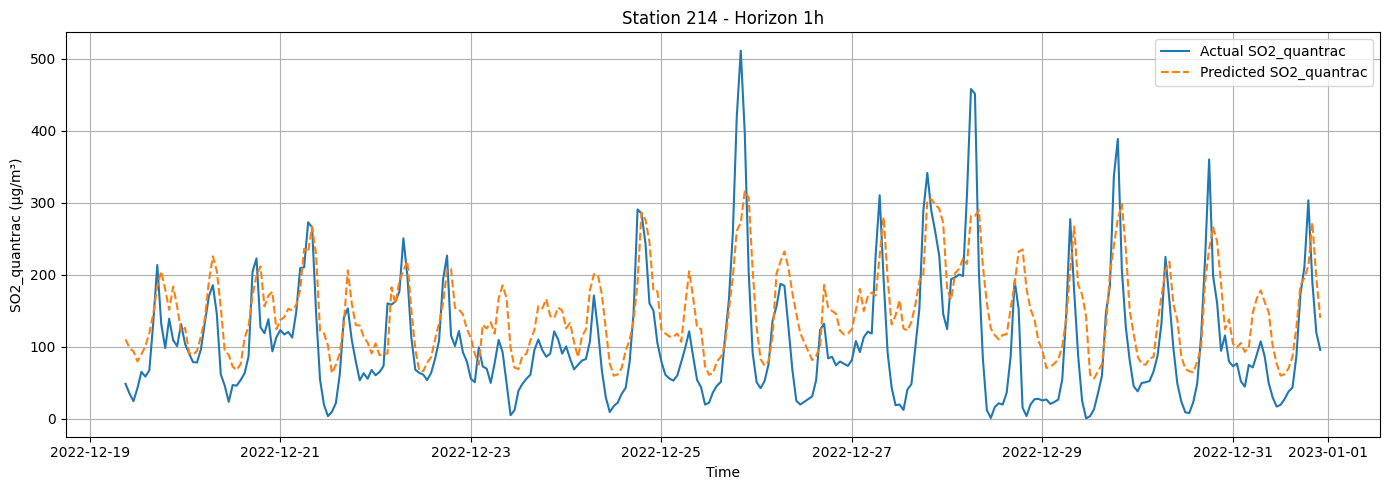

hour = 24
X_test_sid.shape: (844, 53)
y_test_sid.shape: (844, 1)
y_pred_sid.shape: (844,)


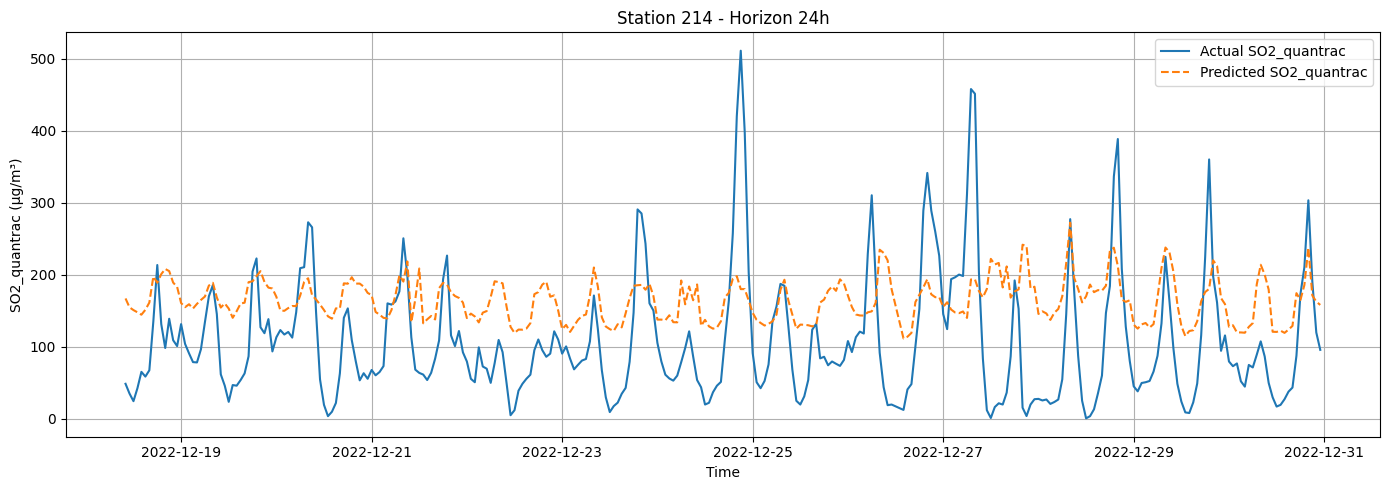

hour = 48
X_test_sid.shape: (840, 53)
y_test_sid.shape: (840, 1)
y_pred_sid.shape: (840,)


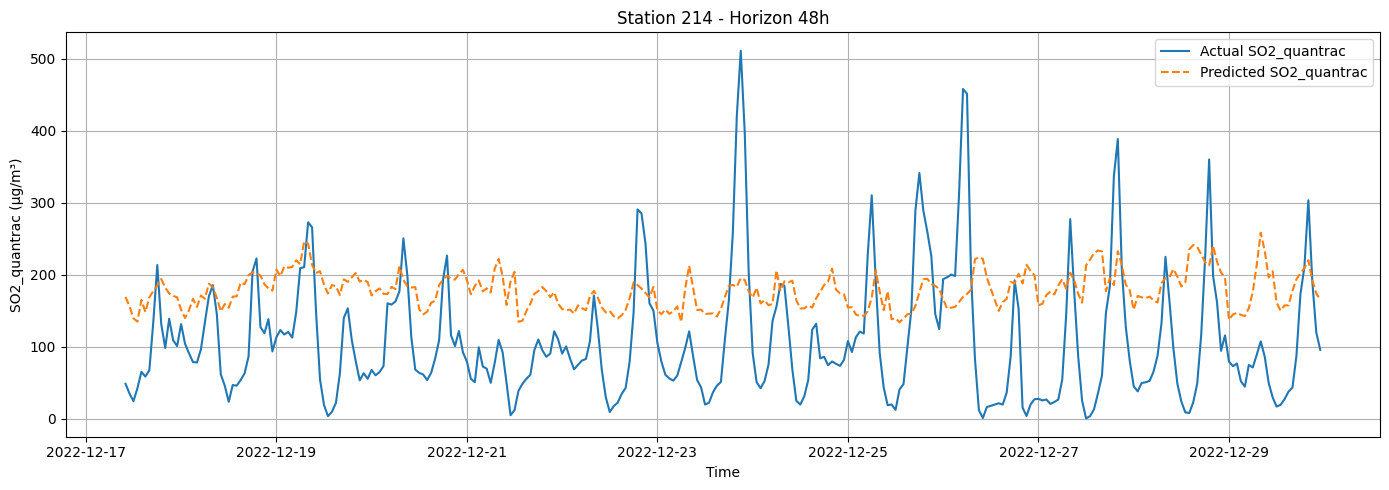

hour = 72
X_test_sid.shape: (837, 53)
y_test_sid.shape: (837, 1)
y_pred_sid.shape: (837,)


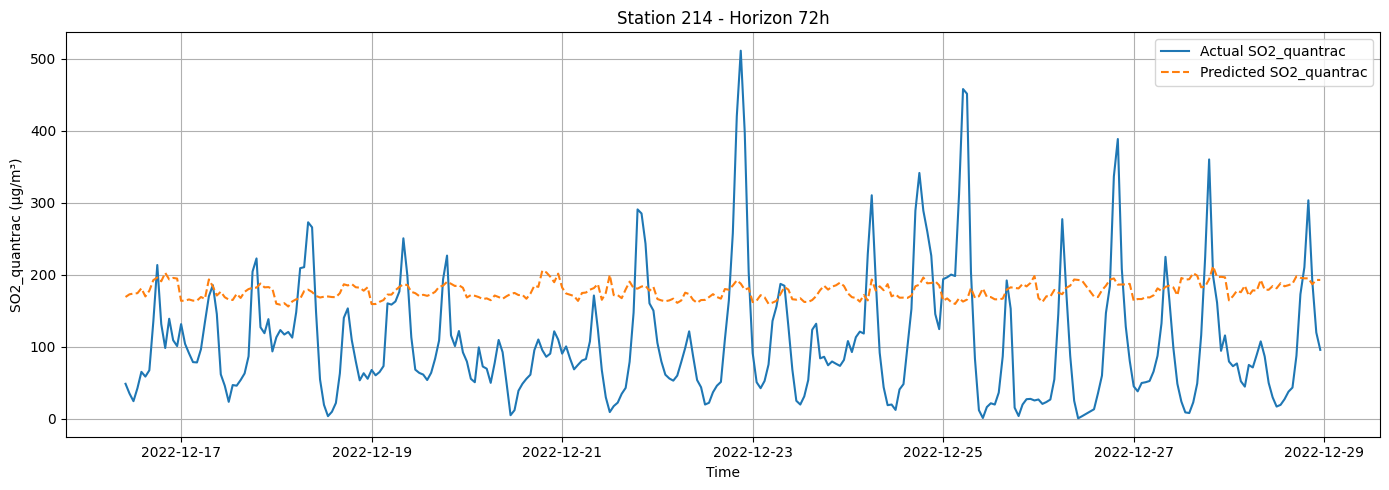

station_id = 216
hour = 1
X_test_sid.shape: (1146, 53)
y_test_sid.shape: (1146, 1)
y_pred_sid.shape: (1146,)


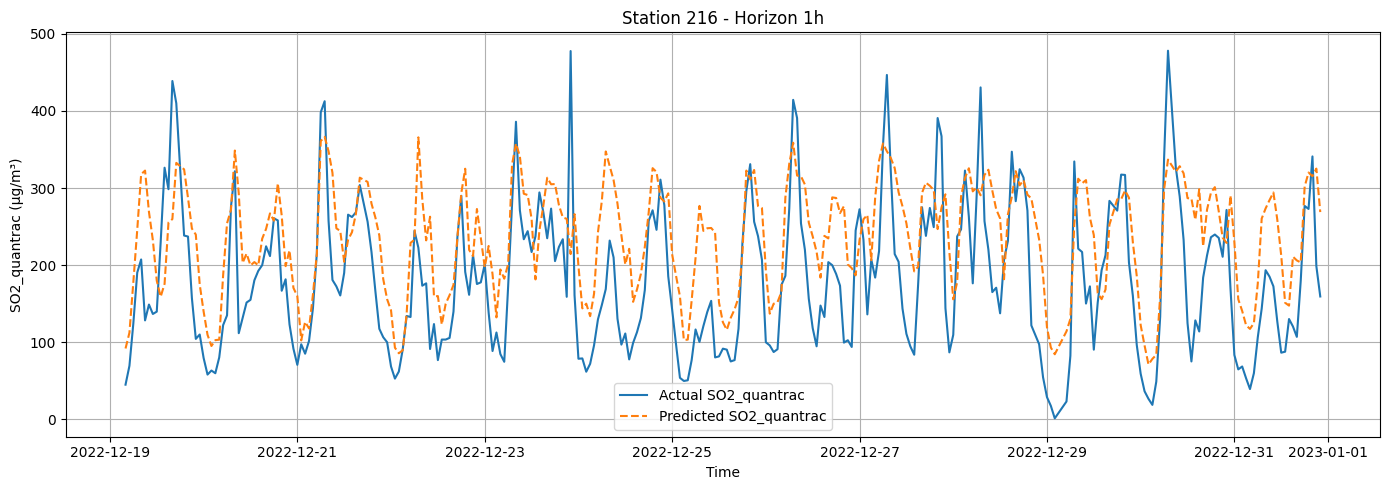

hour = 24
X_test_sid.shape: (1143, 53)
y_test_sid.shape: (1143, 1)
y_pred_sid.shape: (1143,)


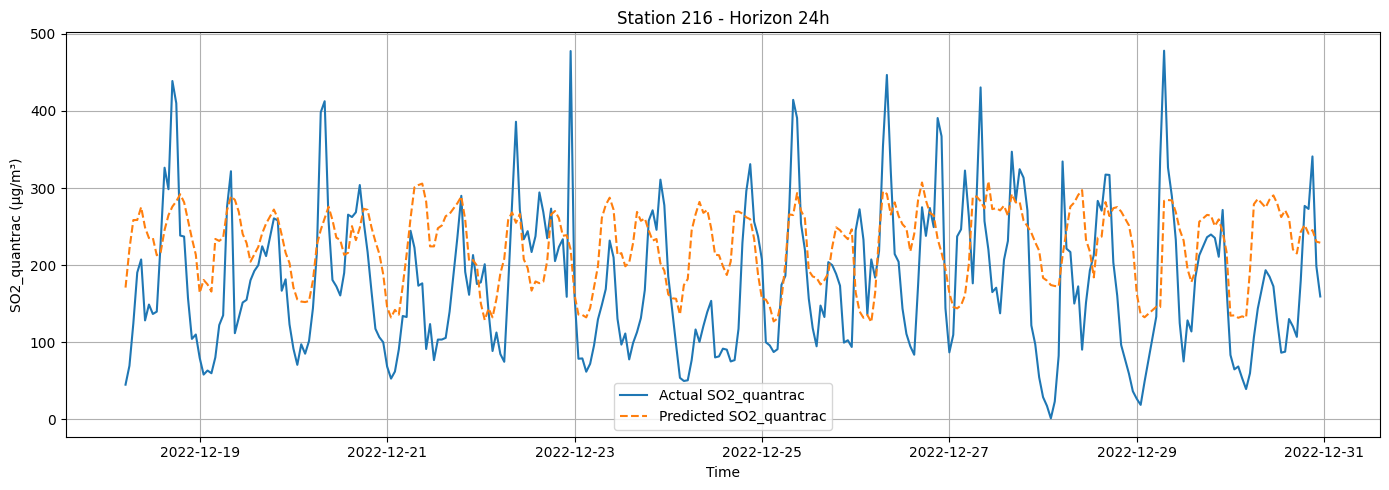

hour = 48
X_test_sid.shape: (1139, 53)
y_test_sid.shape: (1139, 1)
y_pred_sid.shape: (1139,)


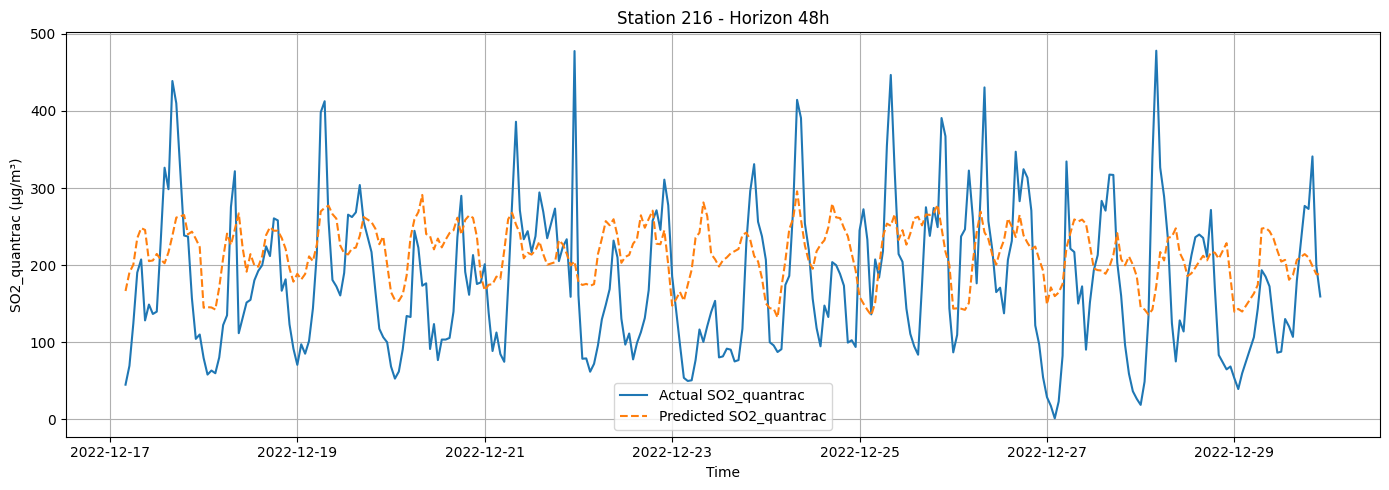

hour = 72
X_test_sid.shape: (1136, 53)
y_test_sid.shape: (1136, 1)
y_pred_sid.shape: (1136,)


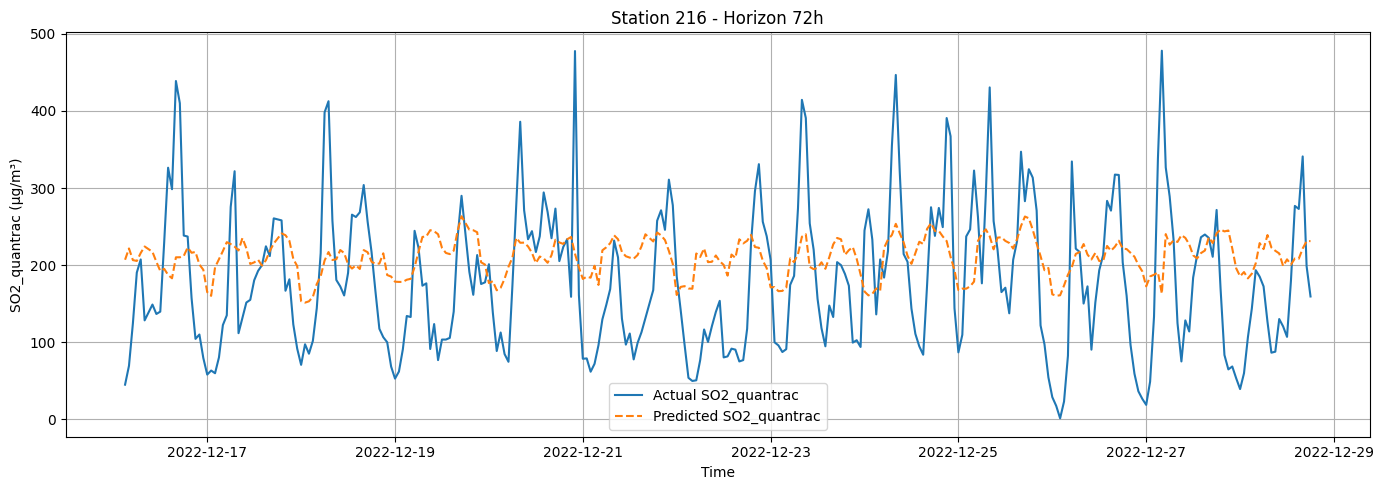

In [17]:
# Reference
for station_id in STATION_IDS:
    print(f"station_id = {station_id}")
    for hour in HORIZONS:
        print(f"hour = {hour}")
        plot_timeseries_example(df_so2, so2_models_by_h[hour], horizon_h=hour, station_id=station_id, target_col=target_col, LIGHTGBM_DIR=LIGHTGBM_DIR)